
### Jupyter Notebook
##  **Learning to steer: a Trajectory Prediction model from Flight Plans**
## Variation with time feature and delta

<br>
<br>
by
<b>Gabriel Mesquida Masana</b><br>
<a href=mailto:gabmm@stanford.edu>gabmm@stanford.edu</a>
<br>

In [1]:
from scene import Scene
from flight import Flight as Fl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import datetime
import math
import pickle
import random

In [59]:
# More output formatting
matplotlib.style.use("seaborn-v0_8-pastel")
pd.options.display.float_format = "{:,.4f}".format
sns.set_style("whitegrid")

# Note this configuration for retina screens only
%config InlineBackend.figure_format = 'retina'

# Only if you're editing the extensions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data from May 24

In [2]:
# Full data May 24
file_name = "24-05_full_exp.pkl"

In [3]:
scene1 = Scene(from_file=file_name)
scene1

Loaded 49884 flights


Scene with 49884 flights, loaded from 24-05_full_exp.pkl.

In [4]:
# Removing some rogue flights that seem to shoot to the moon

# May
if file_name == "24-05_full_exp.pkl":
    scene1.remove(
        [
            "13/05/2024-19:40 AWQ261 WSSS WIII A320",
            "30/05/2024-11:35 AXM140 WMKK ZGOW A320",
            "11/05/2024-10:51 VOZ9943 YPPH WSSL B738",
            "30/05/2024-20:02 SIA297 WSSS NZCH A359",
            "31/05/2024-07:09 SIA934 WSSS WADD B78X",
            "31/05/2024-13:43 AXM278 WMKK WBSB A320",
        ]
    )

Removed 11/05/2024-10:51 VOZ9943 YPPH WSSL B738
Removed 13/05/2024-19:40 AWQ261 WSSS WIII A320
Removed 30/05/2024-11:35 AXM140 WMKK ZGOW A320
Removed 30/05/2024-20:02 SIA297 WSSS NZCH A359
Removed 31/05/2024-07:09 SIA934 WSSS WADD B78X
Removed 31/05/2024-13:43 AXM278 WMKK WBSB A320


In [5]:
# Removing some flights which FPL doesn't match the Trk

# May
if file_name == "24-05_full_exp.pkl":
    scene1.remove(
        [
            "01/05/2024-12:03 AXM6414 WMKJ WMKP A320",
            "04/05/2024-07:18 AXM6412 WMKJ WMKP A320",
            "05/05/2024-22:06 AXM6422 WMKJ WMKP A320",
            "06/05/2024-07:08 AXM6412 WMKJ WMKP A320",
            "08/05/2024-11:45 AXM6043 WMKJ WMKK A320",
            "10/05/2024-07:57 AXM5135 WBKK WMKK A320",
            "11/05/2024-07:15 AXM6412 WMKJ WMKP A320",
            "11/05/2024-13:46 AXM6035 WMKJ WMKK A320",
            "12/05/2024-07:13 AXM6047 WMKJ WMKK A320",
            "13/05/2024-15:30 AXM6454 WMKJ WMKL A320",
            "16/05/2024-07:09 AXM6412 WMKJ WMKP A320",
            "17/05/2024-07:12 AXM6412 WMKJ WMKP A320",
            "17/05/2024-20:58 AXM6422 WMKJ WMKP A320",
            "25/05/2024-06:42 AXM6412 WMKJ WMKP A320",
            "27/05/2024-08:20 AXM6082 WMKJ WMKI A320",
            "28/05/2024-10:55 AWQ551 WMKK WADD A320",
            "29/05/2024-12:16 AXM6414 WMKJ WMKP A320",
            "29/05/2024-15:46 AXM6454 WMKJ WMKL A320",
        ]
    )

Removed 01/05/2024-12:03 AXM6414 WMKJ WMKP A320
Removed 04/05/2024-07:18 AXM6412 WMKJ WMKP A320
Removed 05/05/2024-22:06 AXM6422 WMKJ WMKP A320
Removed 06/05/2024-07:08 AXM6412 WMKJ WMKP A320
Removed 08/05/2024-11:45 AXM6043 WMKJ WMKK A320
Removed 10/05/2024-07:57 AXM5135 WBKK WMKK A320
Removed 11/05/2024-07:15 AXM6412 WMKJ WMKP A320
Removed 11/05/2024-13:46 AXM6035 WMKJ WMKK A320
Removed 12/05/2024-07:13 AXM6047 WMKJ WMKK A320
Removed 13/05/2024-15:30 AXM6454 WMKJ WMKL A320
Removed 16/05/2024-07:09 AXM6412 WMKJ WMKP A320
Removed 17/05/2024-07:12 AXM6412 WMKJ WMKP A320
Removed 17/05/2024-20:58 AXM6422 WMKJ WMKP A320
Removed 25/05/2024-06:42 AXM6412 WMKJ WMKP A320
Removed 27/05/2024-08:20 AXM6082 WMKJ WMKI A320
Removed 28/05/2024-10:55 AWQ551 WMKK WADD A320
Removed 29/05/2024-12:16 AXM6414 WMKJ WMKP A320
Removed 29/05/2024-15:46 AXM6454 WMKJ WMKL A320


## Overflights and Airbus 320

In [6]:
scene2 = Scene(from_scene=scene1).overflights().aircraft(aircraft="A320")
scene2

Scene with 7456 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320.

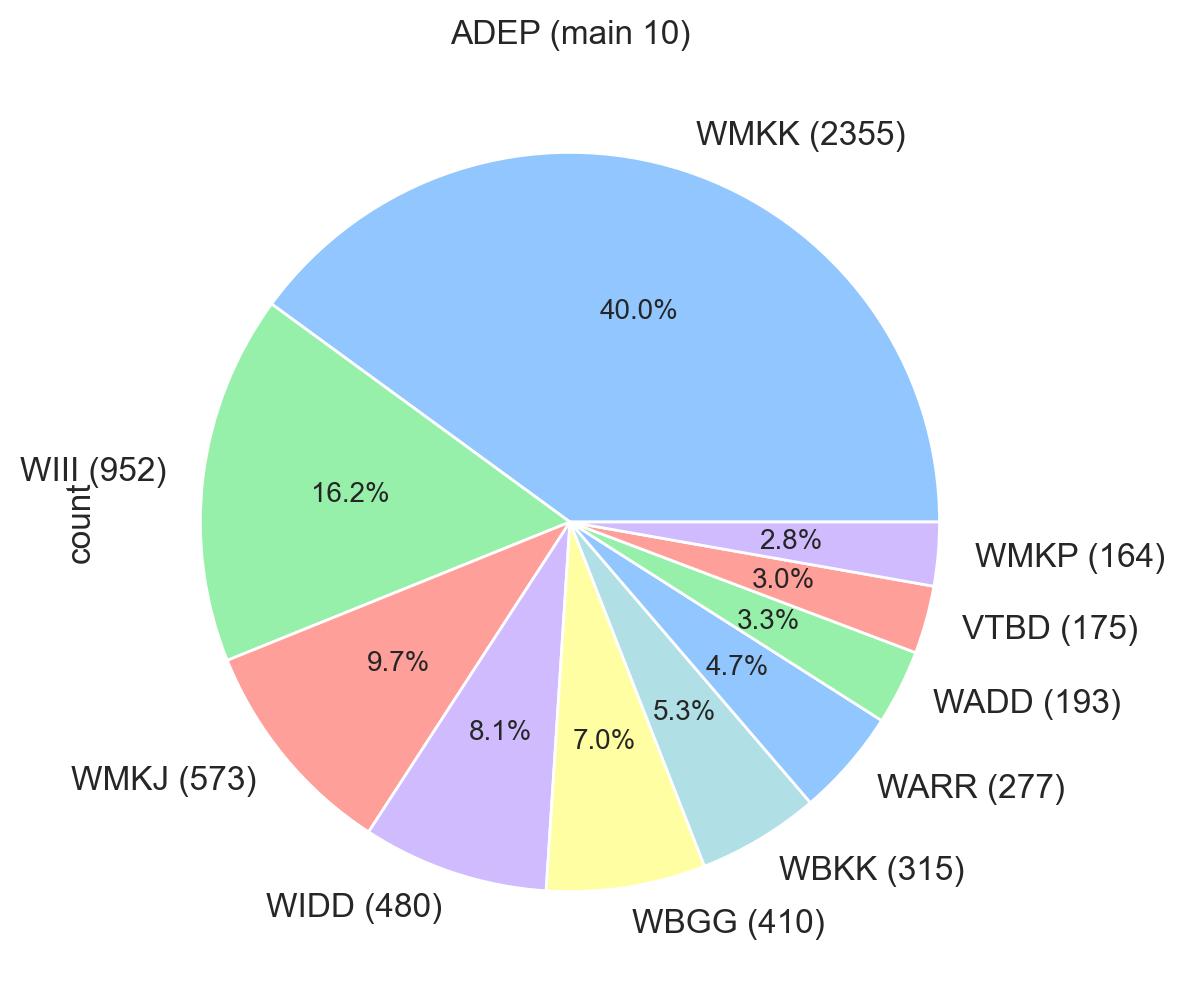

In [7]:
scene2.query_attribute(attribute="ADEP", pie=True)

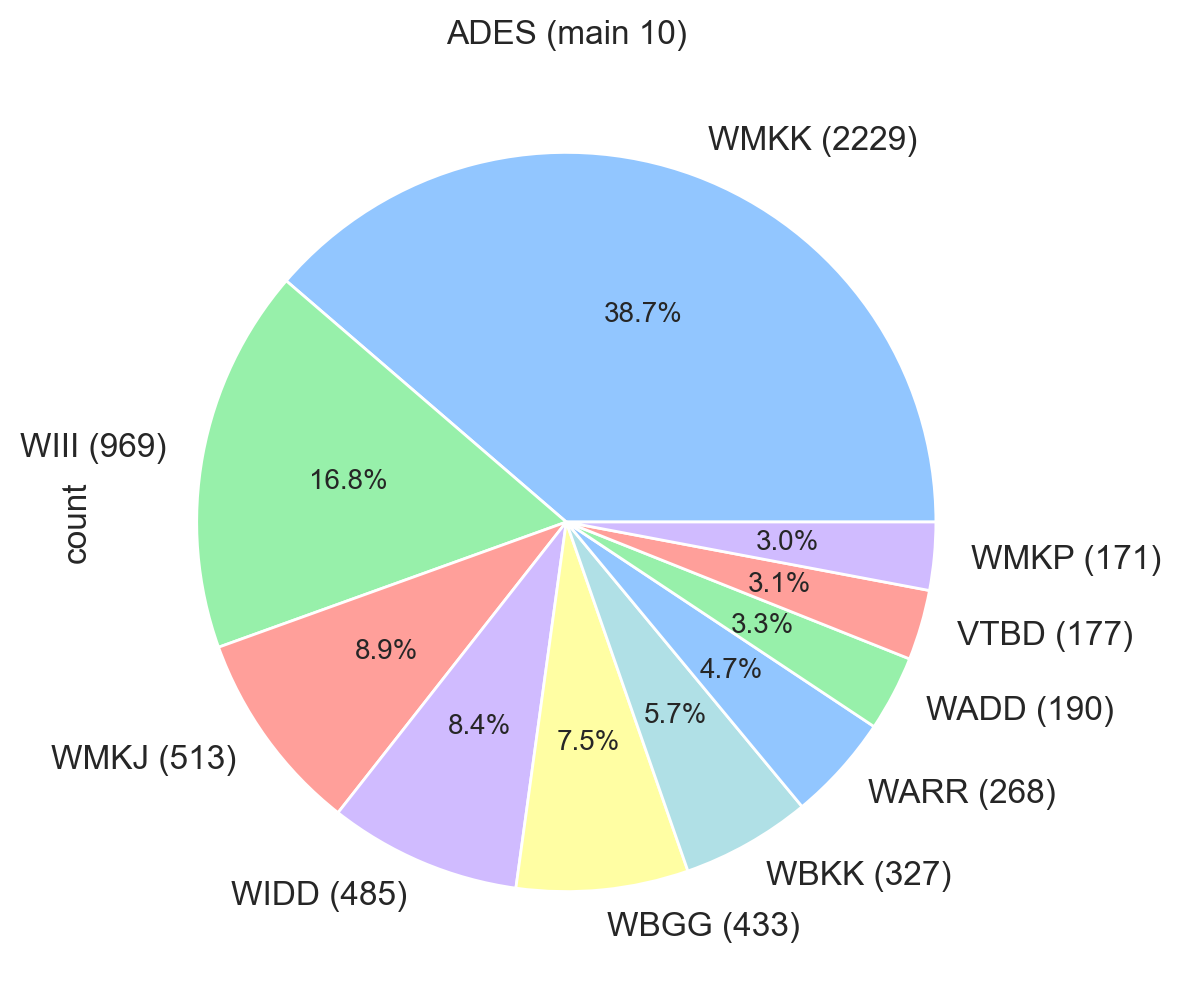

In [8]:
scene2.query_attribute(attribute="ADES", pie=True)

## Make sure FPL and Tracks are consistent

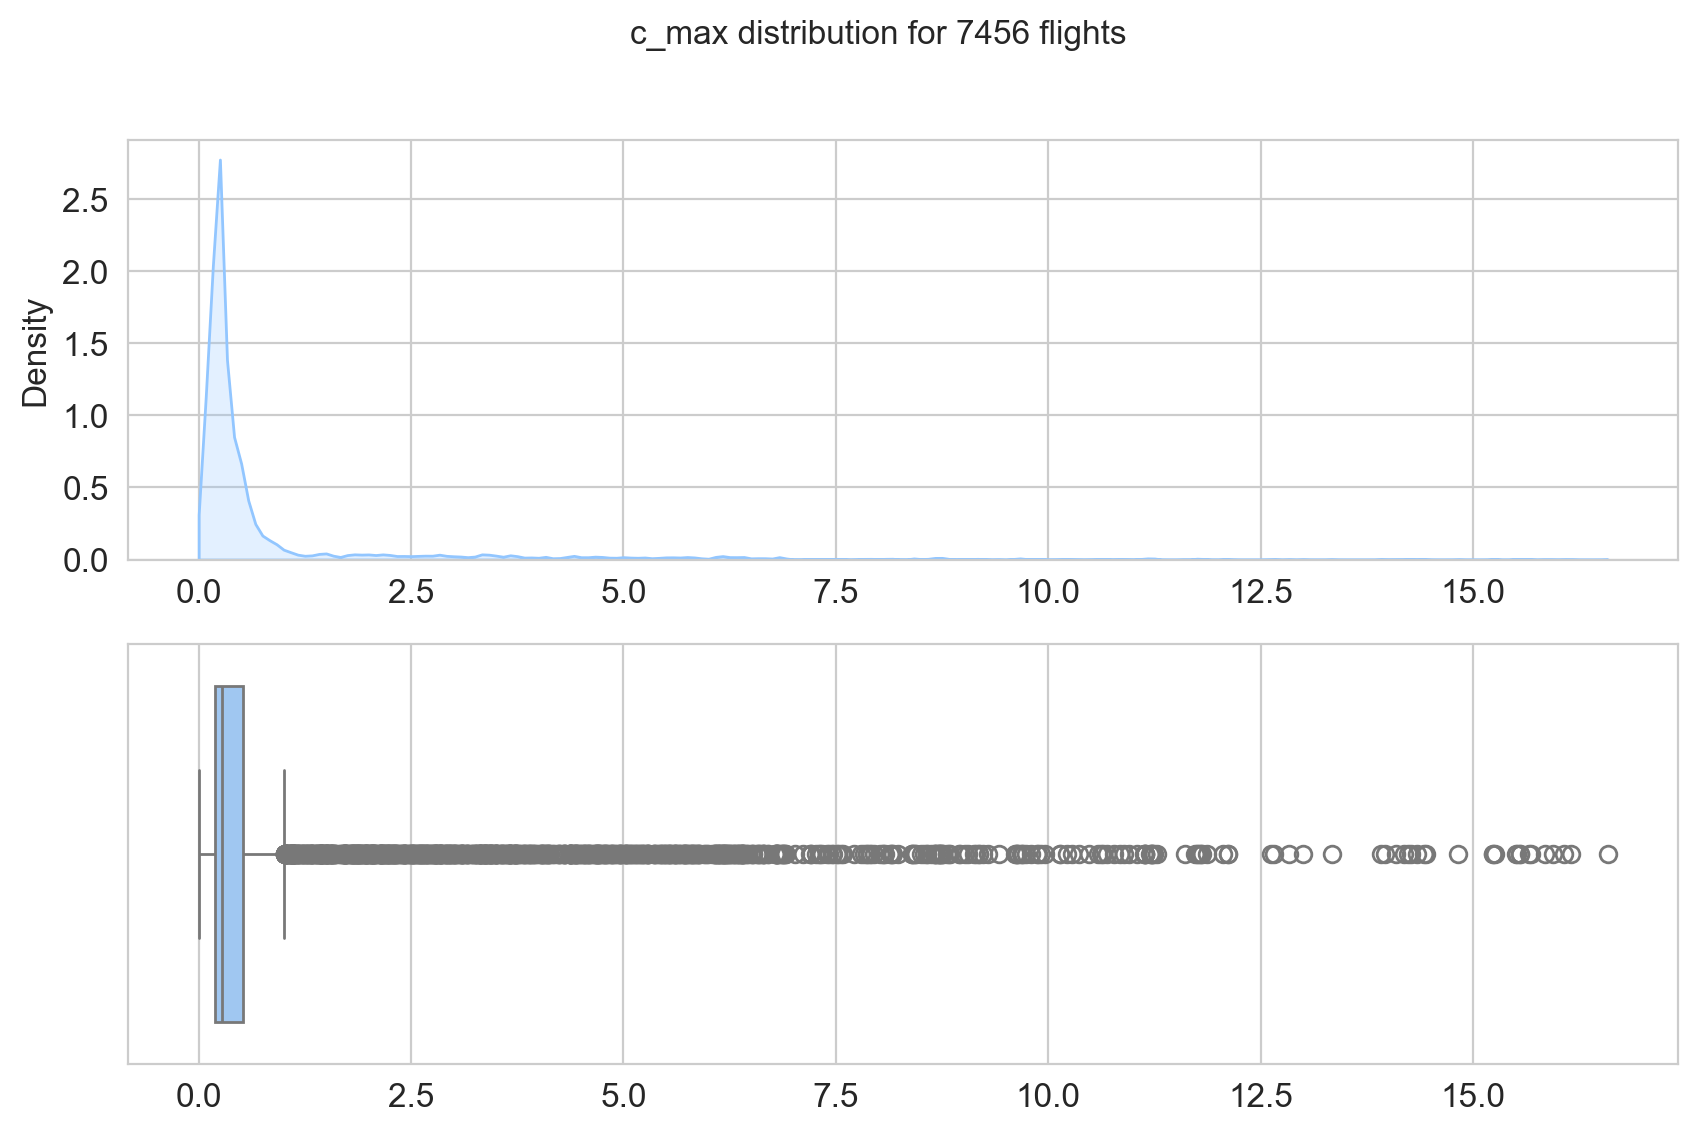

In [9]:
scene2.plot_c()

In [10]:
scene3, _ = scene2.split_c(c_threshold=1)
scene3

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1.

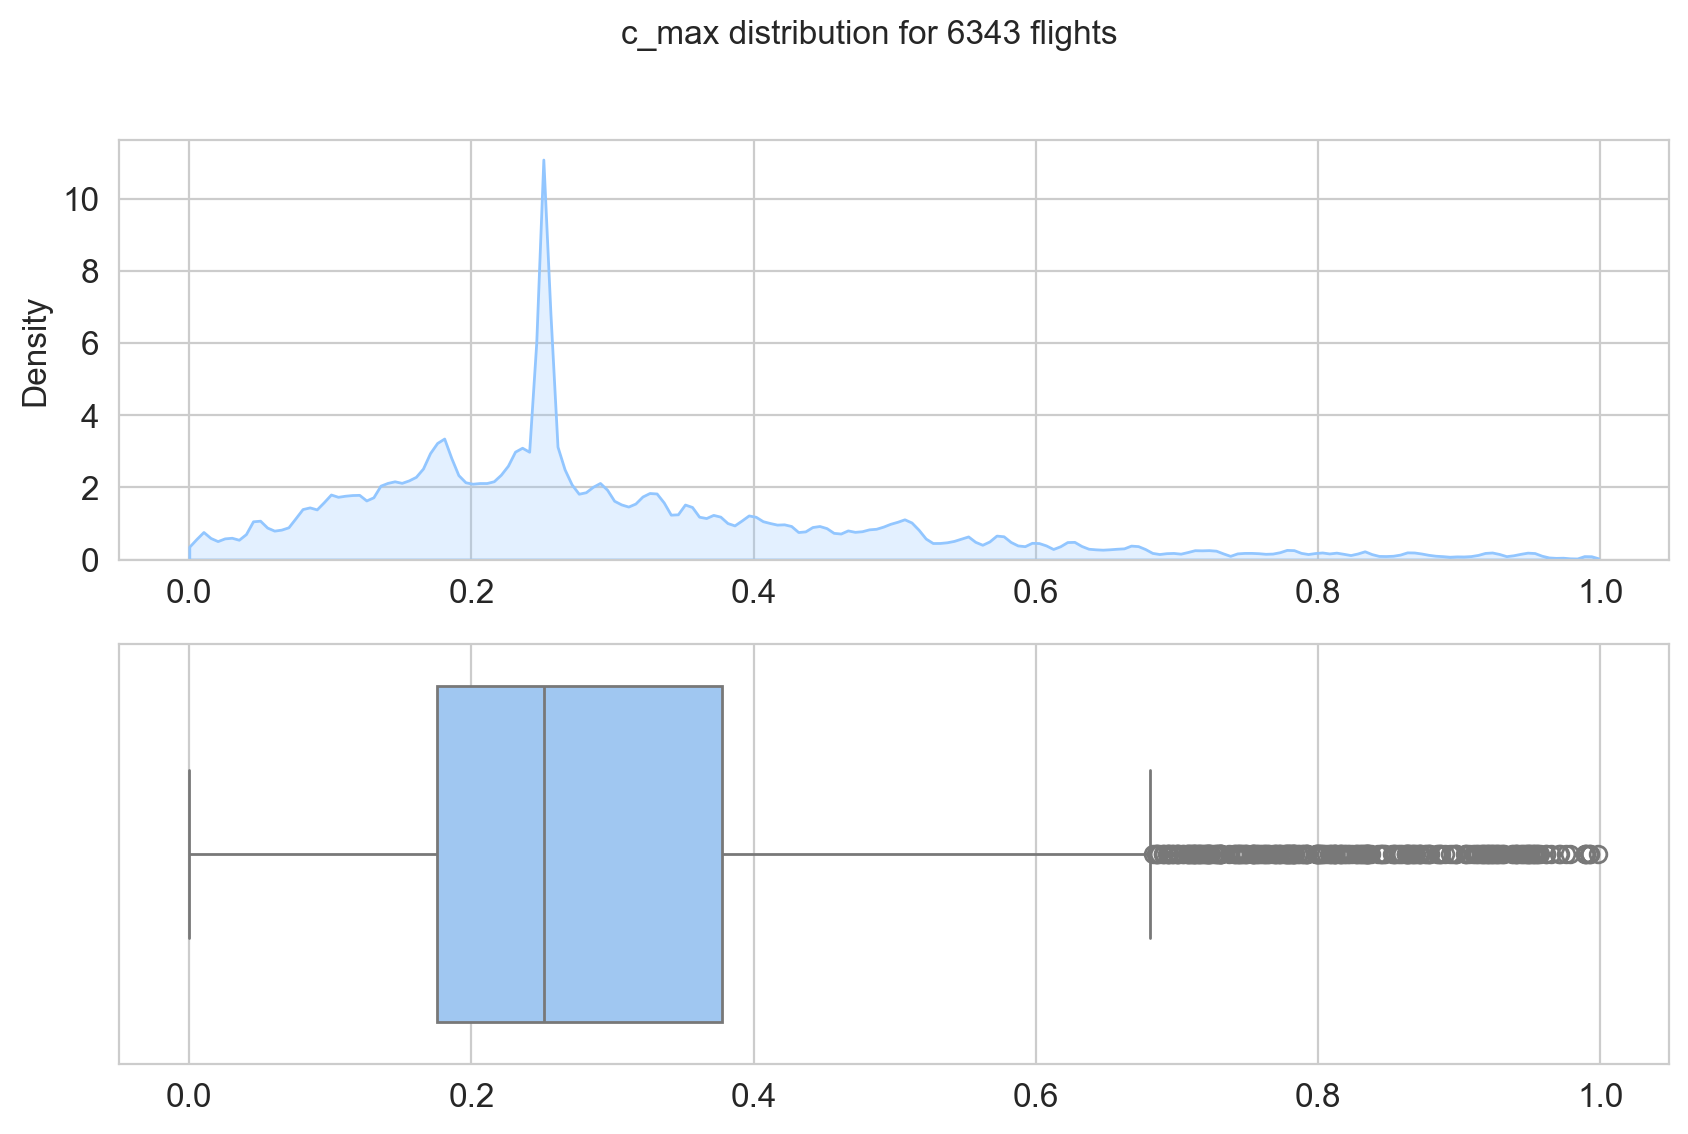

In [11]:
scene3.plot_c()

## Downsampling flights

* Down to every 20 seconds

In [12]:
scene3.downsample(factor=5)
scene3.flights[0].additional["time_gap"]

# see below for new sampling period

20

* Take a look at the elevation profiles. We could just select the cruise phase and have more clean data as an improvement idea.

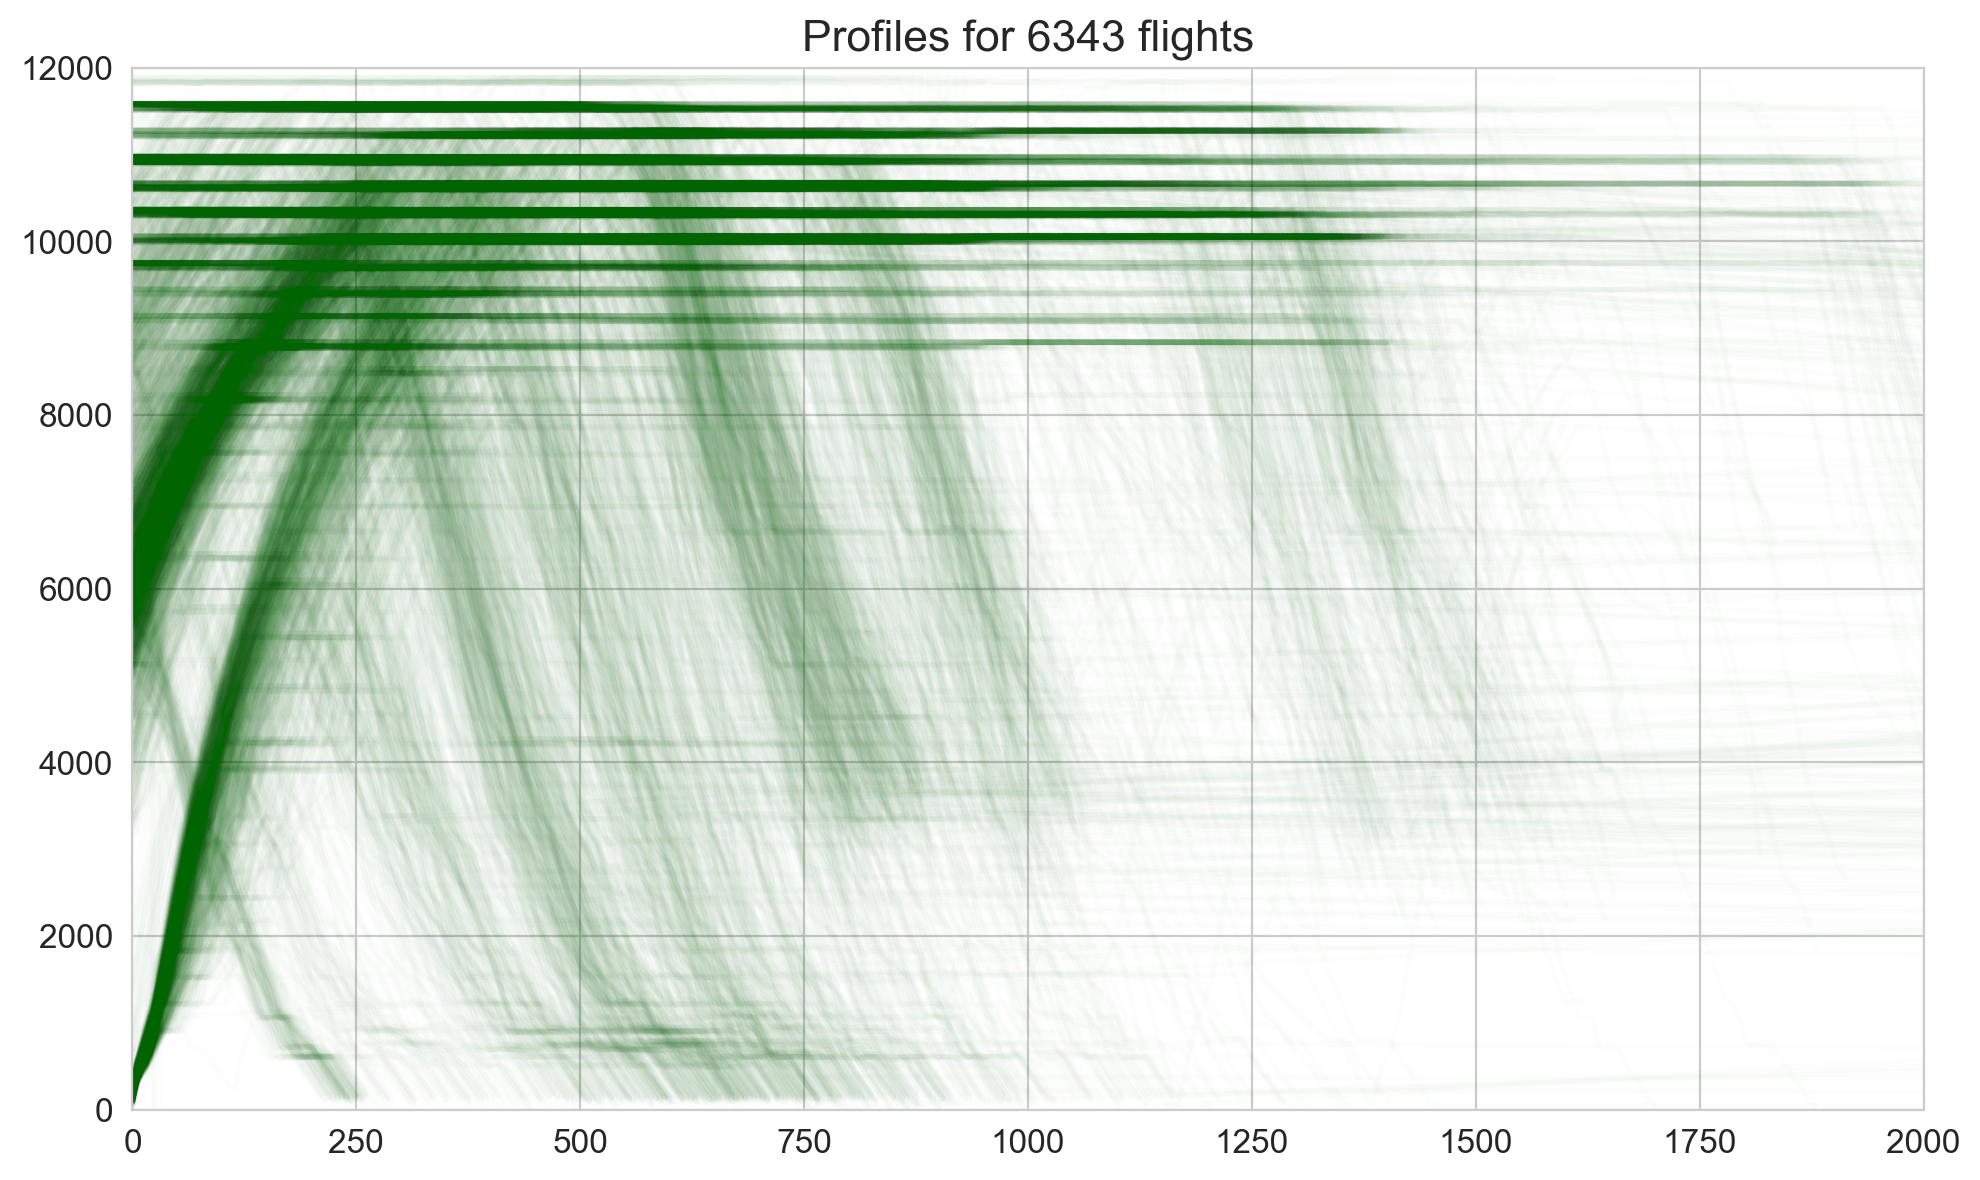

In [24]:
scene3.plot_elevation_profile(
    endalign=False, xlim=2000, ylim=(0, 12000), alpha=0.01
)

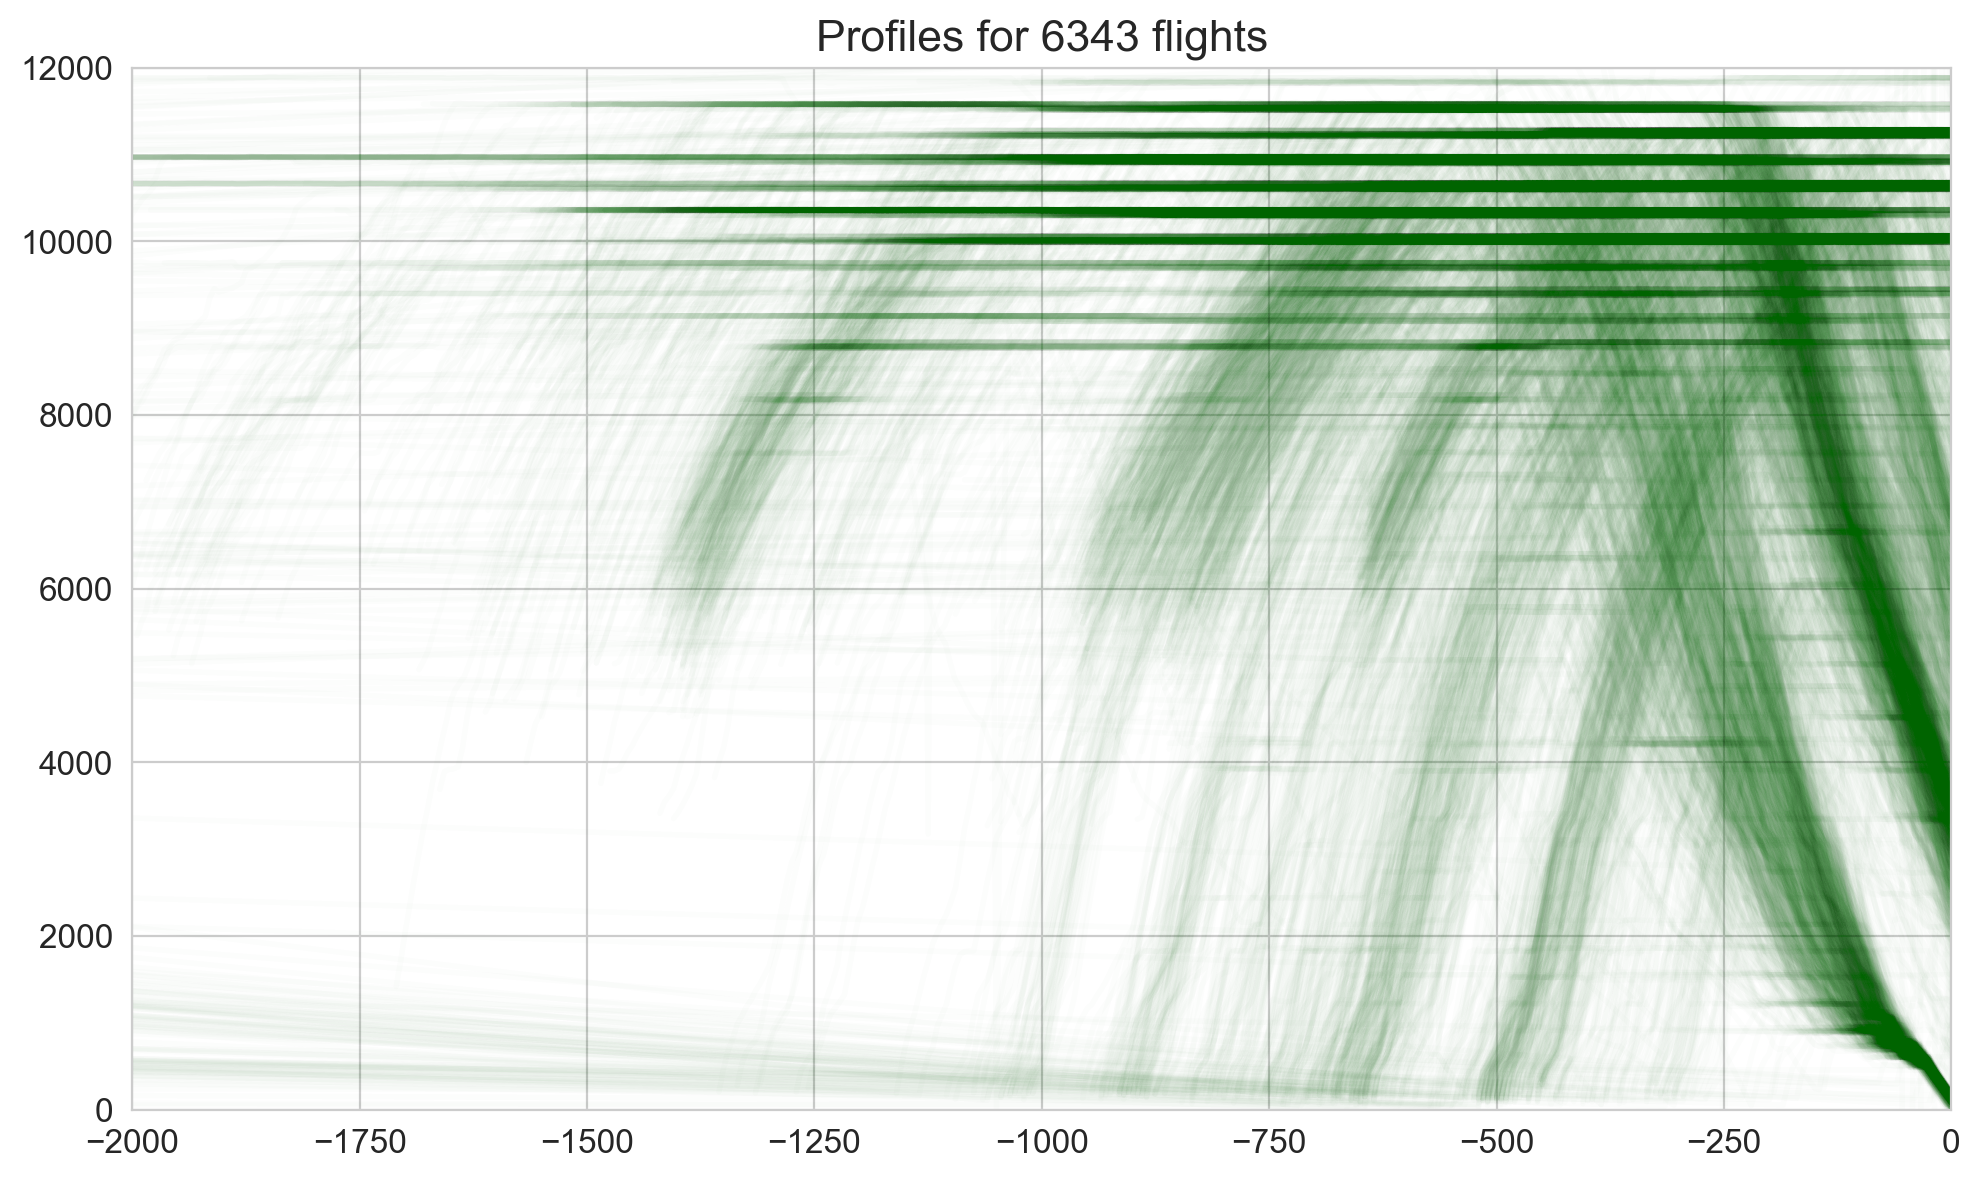

In [25]:
scene3.plot_elevation_profile(
    endalign=True, xlim=2000, ylim=(0, 12000), alpha=0.01
)

## Creating projections

In [14]:
scene3.project()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection.

### Matching projection with tracks

In [15]:
scene3.match_project()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left.

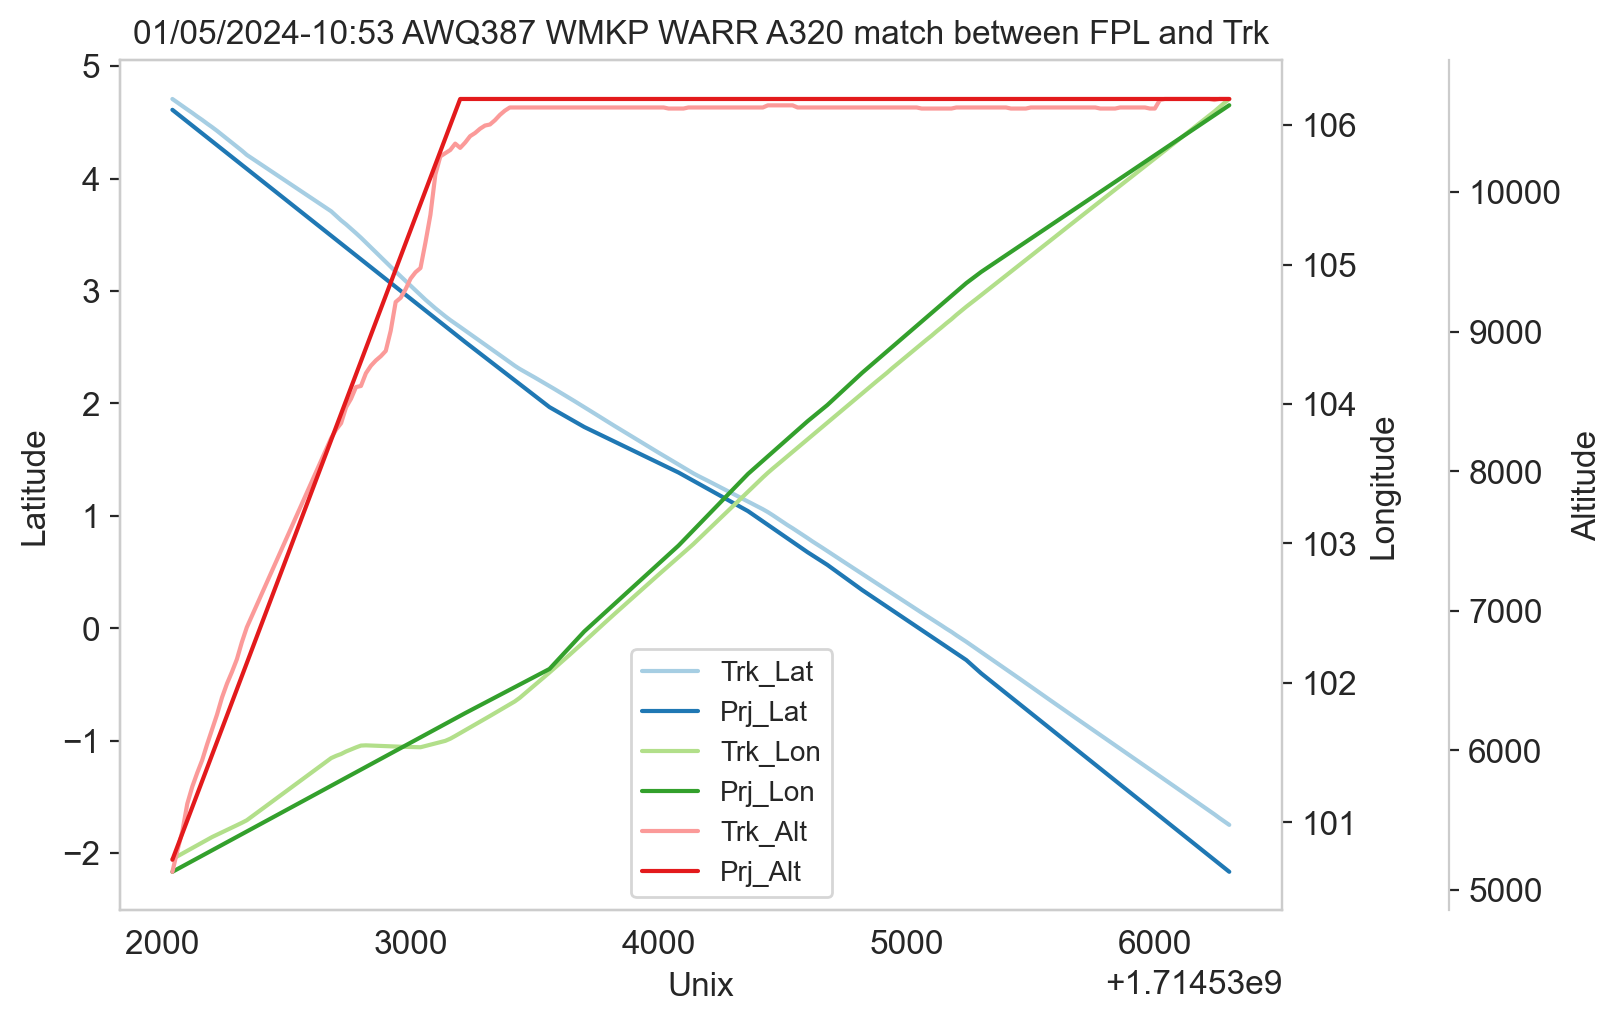

In [50]:
scene3[23].plot_match(geo=True)

### Changing geodesic coordinates to ENU

In [17]:
scene3.match_convert_geo_to_enu()

Scene with 6343 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU.

See how the curvature of the planet now appears below:

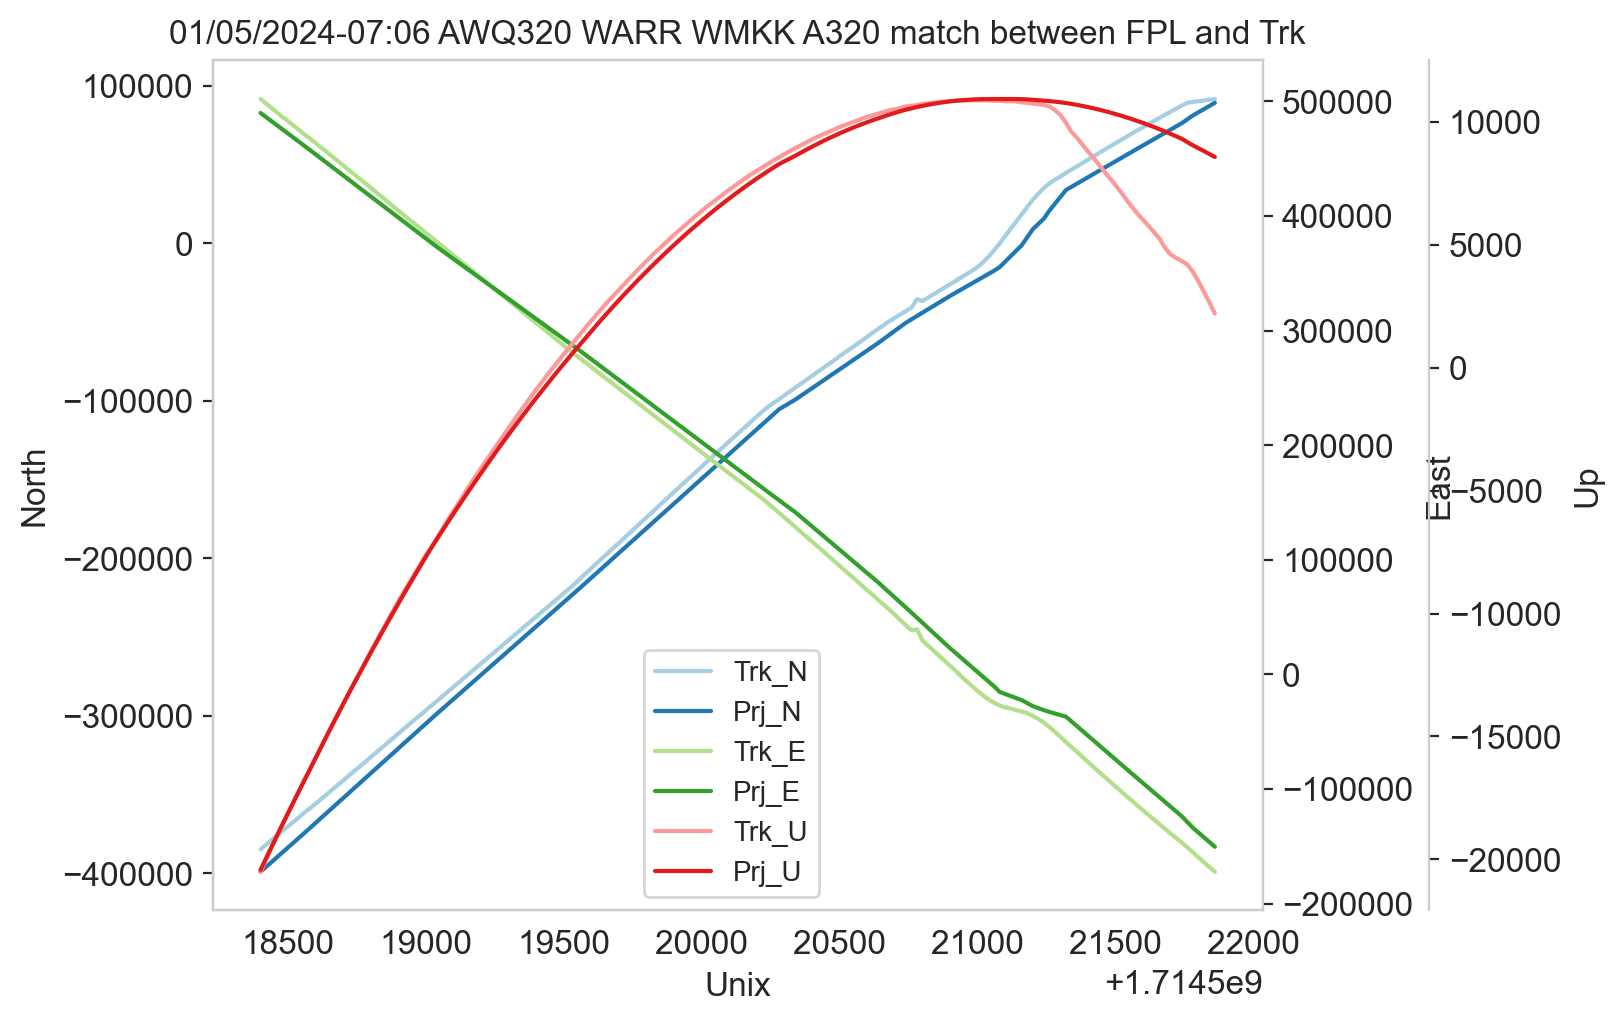

In [19]:
scene3.flights[1].plot_match(geo=False)

### Standardisation of position and time data

In [55]:
scene3.match_standardise_enu()
TRANSFORMATION = scene3.match_enu_transform
TRANSFORMATION

{'e_max': 1517300.8775228173,
 'e_min': -489316.4886358802,
 'n_max': 1256678.2131043493,
 'n_min': -539681.7837180963,
 'u_max': 18987.70587689134,
 'u_min': -284450.3060762797,
 'steps_max': 446}

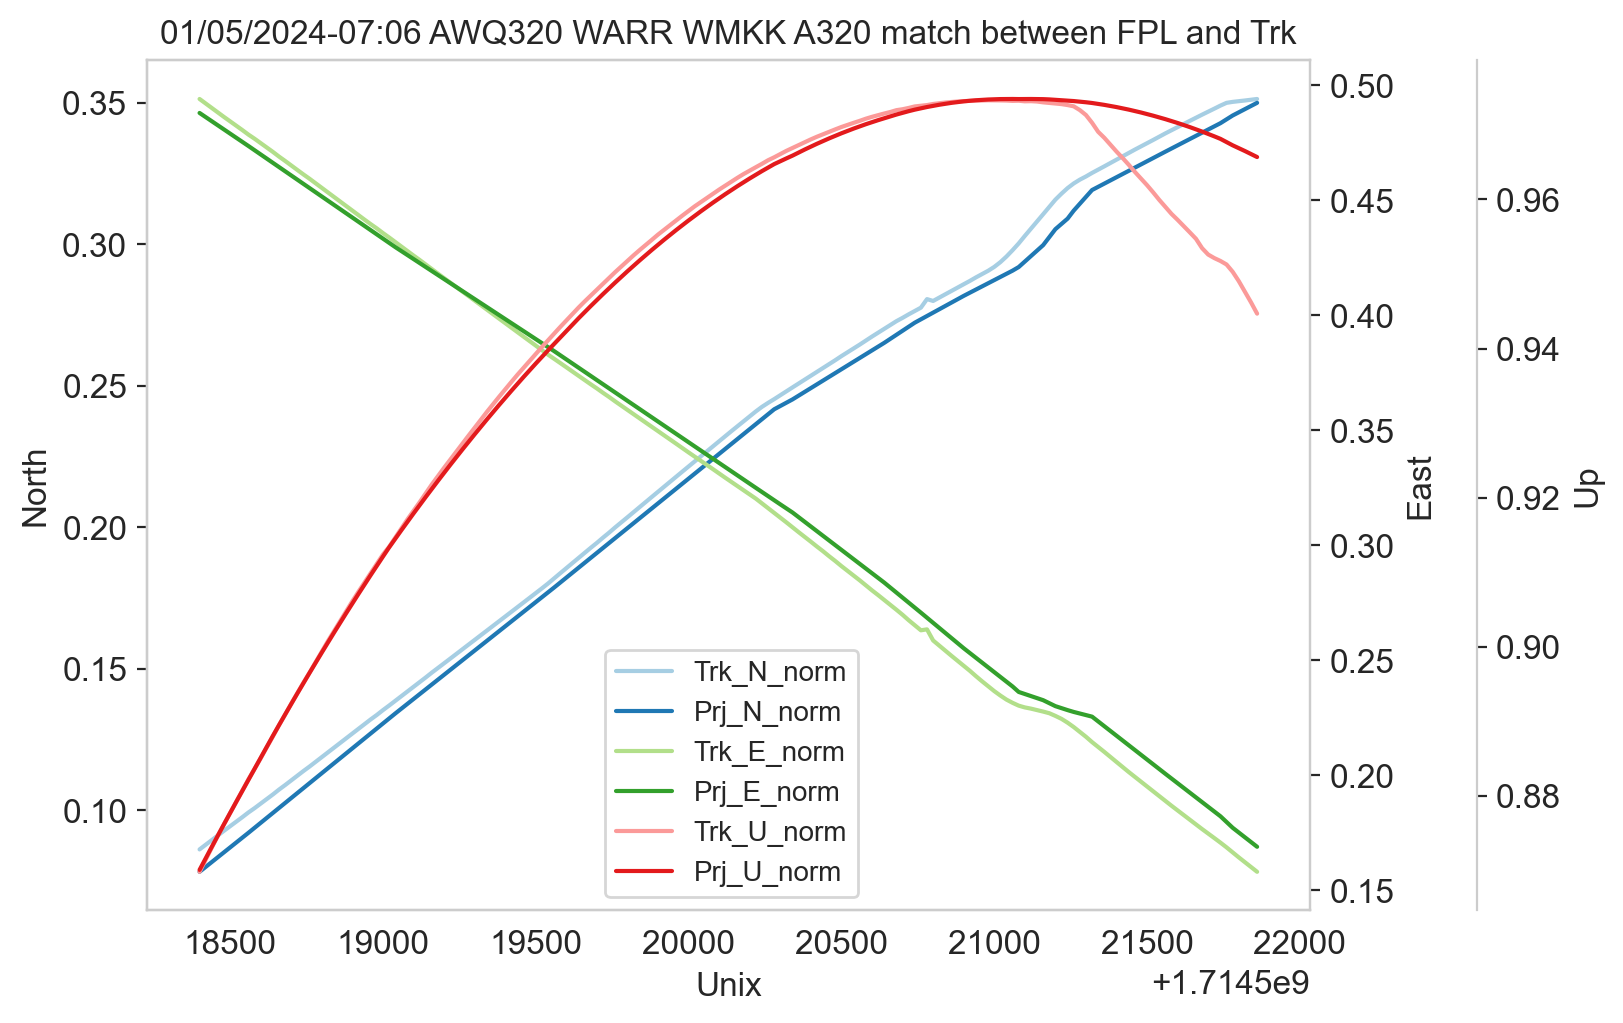

In [56]:
scene3.flights[1].plot_match(geo=False, norm=True)

In [ ]:
SAVE_STANDARDISATION = False

if SAVE_STANDARDISATION:
    with open("logs/over_a320_std_enu_transform.pickle", "wb") as handle:
        pickle.dump(
            scene3.match_enu_transform,
            handle,
            protocol=pickle.HIGHEST_PROTOCOL,
        )

* Dataframe created

In [61]:
scene3.flights[1].match

Unix  Trk_Lat  Trk_Lon     Trk_Alt    Trk_Vx   Trk_Vy  Prj_Lat  \
0    1714518400  -2.1213 108.5012 10,965.1796 -180.7500 139.5000  -2.2495   
1    1714518420  -2.0943 108.4657 10,965.1796 -187.5000 143.0000  -2.2216   
2    1714518440  -2.0680 108.4308 10,972.7996 -192.7500 145.0000  -2.1936   
3    1714518460  -2.0400 108.3940 10,972.7996 -199.2500 150.5000  -2.1656   
4    1714518480  -2.0139 108.3596 10,972.7996 -192.5000 145.5000  -2.1376   
..          ...      ...      ...         ...       ...      ...      ...   
169  1714521780   2.1692 102.5967  6,431.2798 -218.5000  33.5000   2.0907   
170  1714521800   2.1730 102.5578  6,164.5798 -217.7500  24.2500   2.1088   
171  1714521820   2.1772 102.5199  5,844.5398 -214.5000  23.5000   2.1270   
172  1714521840   2.1816 102.4820  5,532.1198 -210.7500  24.0000   2.1452   
173  1714521860   2.1859 102.4443  5,189.2198 -207.7500  24.2500   2.1633   

     Prj_Lon     Prj_Alt    Prj_V  ...         Prj_E         Prj_N  \
0   108.3918 10,972.7996 457.2858  ...  489,870.9336 -399,013.0809   
1   108.3594 10,972.7996 456.9593  ...  486,275.6001 -395,925.2248   
2   108.3269 10,972.7996 456.6327  ...  482,679.8596 -392,837.2272   
3   108.2945 10,972.7996 456.3062  ...  479,083.7159 -389,749.0888   
4   108.2621 10,972.7996 455.9796  ...  475,487.1727 -386,660.8103   
..       ...         ...      ...  ...           ...           ...   
169 102.7908 10,972.7996 453.0000  ... -133,753.6214   81,056.5140   
170 102.7535 10,972.7996 453.0000  ... -137,904.7459   83,070.8254   
171 102.7162 10,972.7996 453.0000  ... -142,055.7019   85,085.1929   
172 102.6789 10,972.7996 453.0000  ... -146,206.4865   87,099.6163   
173 102.6417 10,972.7996 453.0000  ... -150,357.0966   89,114.0955   

           Prj_U  Trk_E_norm  Trk_N_norm  Trk_U_norm  Prj_E_norm  Prj_N_norm  \
0   -20,427.8790      0.4941      0.0862      0.8698      0.4880      0.0783   
1   -19,957.5374      0.4921      0.0879      0.8715      0.4862      0.0800   
2   -19,490.7334      0.4902      0.0895      0.8731      0.4844      0.0817   
3   -19,027.4676      0.4881      0.0912      0.8747      0.4826      0.0835   
4   -18,567.7403      0.4862      0.0928      0.8762      0.4808      0.0852   
..           ...         ...         ...         ...         ...         ...   
169   9,054.8524      0.1665      0.3504      0.9503      0.1772      0.3456   
170   8,940.5205      0.1643      0.3506      0.9491      0.1751      0.3467   
171   8,822.8520      0.1622      0.3509      0.9476      0.1731      0.3478   
172   8,701.8471      0.1601      0.3511      0.9462      0.1710      0.3489   
173   8,577.5060      0.1580      0.3514      0.9447      0.1689      0.3500   

     Prj_U_norm  Steps_norm  
0        0.8701      0.0000  
1        0.8717      0.0022  
2        0.8732      0.0045  
3        0.8747      0.0067  
4        0.8762      0.0090  
..          ...         ...  
169      0.9673      0.3789  
170      0.9669      0.3812  
171      0.9665      0.3834  
172      0.9661      0.3857  
173      0.9657      0.3879  

[174 rows x 40 columns]

* Total of flights transformed

In [62]:
len(scene3.flights)

6343

# Transforming data into features

### Split data

In [63]:
train, dev, test = scene3.split_train_dev_test(trainpct=80, devpct=10)
train, dev, test

(Scene with 5115 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU, ENU standardisation added, ENU standardisation added, 80% for train.,
 Scene with 614 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geodesic to ENU, ENU standardisation added, ENU standardisation added, 10% for dev.,
 Scene with 614 flights, copy of object (loaded from 24-05_full_exp.pkl, removed 6 flights, removed 18 flights), overflights, aircraft is A320, c<=1, thinned to every 20s, created projection, tracks longer than 600 seconds, matched projections, 6343 flights left, converted Geode

## Transform into features

* Take all possible blocks of 5 to 15 minutes of matched FPL projection and track from each flight
* Data is already standardised by library
* Convert to numpy, reshape, split into X and Y and concatenate

In [64]:
SAMPLES = Scene.MINMATCHTIME // int(train.flights[0].additional["time_gap"])
MINSAMPLES = 16  # the first 5 minutes must be there, plus one sample
BATCH_SIZE = 16
SAMPLES  # Number of samples needed below

45

In [79]:
def data_from_flight(flight, samples):
    """
    Creates a block of data ready to train or test climb model
    from a flight

    shape ``[seq_len, batch_size, embedding_dim]``

    where embedding takes into account all params
    """
    output = pd.DataFrame(columns=[])

    for i in range(samples):
        for p in [
            "Trk_E_norm",
            "Trk_N_norm",
            "Trk_U_norm",
            "Steps_norm",
            "Prj_E_norm",
            "Prj_N_norm",
            "Prj_U_norm",
        ]:
            output[p + "_" + str(i).zfill(2)] = flight.match[p].shift(
                periods=-i
            )

    output = output.to_numpy()
    output = output.reshape(output.shape[0], samples, 7)
    Y = output[:, :, 0:4]  # .transpose([1, 0, 2])
    X = np.zeros((output.shape[0], samples, 4))
    X[:, :, 0:3] = output[:, :, 4:7]
    X[:, :, 3:4] = output[:, :, 3:4]

    return X, Y


def data_from_scene(scene):
    """
    Creates a block of data ready to train or test the climb model
    from a list of flights
    """
    xs = np.array([]).reshape(0, 45, 4)
    ys = np.array([]).reshape(0, 45, 4)

    for flight in scene:
        x_, y_ = data_from_flight(flight=flight, samples=SAMPLES)
        xs = np.concatenate([xs, x_], axis=0)
        ys = np.concatenate([ys, y_], axis=0)

    return xs, ys

In [ ]:
# Takes a while... 30 min

train_X, train_Y = data_from_scene(train)
dev_X, dev_Y = data_from_scene(dev)
test_X, test_Y = data_from_scene(test)

train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

((836682, 45, 4),
 (836682, 45, 4),
 (98645, 45, 4),
 (98645, 45, 4),
 (101796, 45, 4),
 (101796, 45, 4))

In [ ]:
# Save the files or recover them (deactivated by default)
# (because of the slow previous step)

save = False  # change to True to save
load = True  # change to True to load

# Because of saving without the class, need full path
if save:
    np.savez(
        file=Fl.DEFAULT_DATA_DIR_NAME + "tp_data_set_time",
        train_X=train_X,
        train_Y=train_Y,
        dev_X=dev_X,
        dev_Y=dev_Y,
        test_X=test_X,
        test_Y=test_Y,
    )
elif load:
    with np.load(
        Fl.DEFAULT_DATA_DIR_NAME + "tp_data_set_time" + ".npz"
    ) as data:
        train_X = data["train_X"]
        train_Y = data["train_Y"]
        dev_X = data["dev_X"]
        dev_Y = data["dev_Y"]
        test_X = data["test_X"]
        test_Y = data["test_Y"]

train_X.shape, train_Y.shape, dev_X.shape, dev_Y.shape, test_X.shape, test_Y.shape

((836682, 45, 4),
 (836682, 45, 4),
 (98645, 45, 4),
 (98645, 45, 4),
 (101796, 45, 4),
 (101796, 45, 4))

## Into tensor, datasets & dataloaders

In [114]:
# Outputs are going to be [Batch, Sequence, Embedding]

train_dataset = TensorDataset(
    torch.tensor(train_X, dtype=torch.float),
    torch.tensor(train_Y, dtype=torch.float),
)
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

dev_dataset = TensorDataset(
    torch.tensor(dev_X, dtype=torch.float),
    torch.tensor(dev_Y, dtype=torch.float),
)
dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataset = TensorDataset(
    torch.tensor(test_X, dtype=torch.float),
    torch.tensor(test_Y, dtype=torch.float),
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

## ML Model

### Creation of TP transformer model

In [115]:
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# Unfortunately mps goes slower than cpu
if DEVICE == "mps":
    DEVICE = "cpu"

DEVICE  # see below

'cpu'

In [116]:
# Max Len already stored in SAMPLES
ENCODING_DIM = 4  # Four signals
EMBEDDING_DIM = 4  # ENU
ENCODING_LAYERS = 4
DECODING_LAYERS = 4
DROPOUT_POSITIONAL = 0.1
DROPOUT_TRANSFORMER = 0.1
HEADS = 8  # Must be encoding + embedding or multiple
SAMPLES, BATCH_SIZE, SAMPLES, MINSAMPLES  # Echo dragged constants

(45, 16, 45, 16)

In [117]:
class PositionalEncoding(nn.Module):
    """
    Source PyTorch documentation

    Modified GMM to alter shape to fit with dataloaders
    Outputs are going to be [Batch, Sequence, Embedding]
    """

    def __init__(
        self,
        d_model: int,
        dropout: float = 0.1,
        max_len: int = 5000,
        device=DEVICE,
    ):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            input=torch.arange(0, d_model, 2)
            * (-math.log(100) / d_model)  # Changed GMM 10,000
        )
        pe = torch.zeros(1, max_len, d_model)
        # Sequence Number Embedding
        pe[0, :, 0::2] = torch.sin(position * div_term) * 0.1
        pe[0, :, 1::2] = torch.cos(position * div_term) * 0.1
        self.register_buffer("pe", pe.to(DEVICE))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.cat(
            tensors=[x, self.pe[: x.size(0)].expand(x.shape[0], -1, -1)], dim=2
        )
        return self.dropout(x)

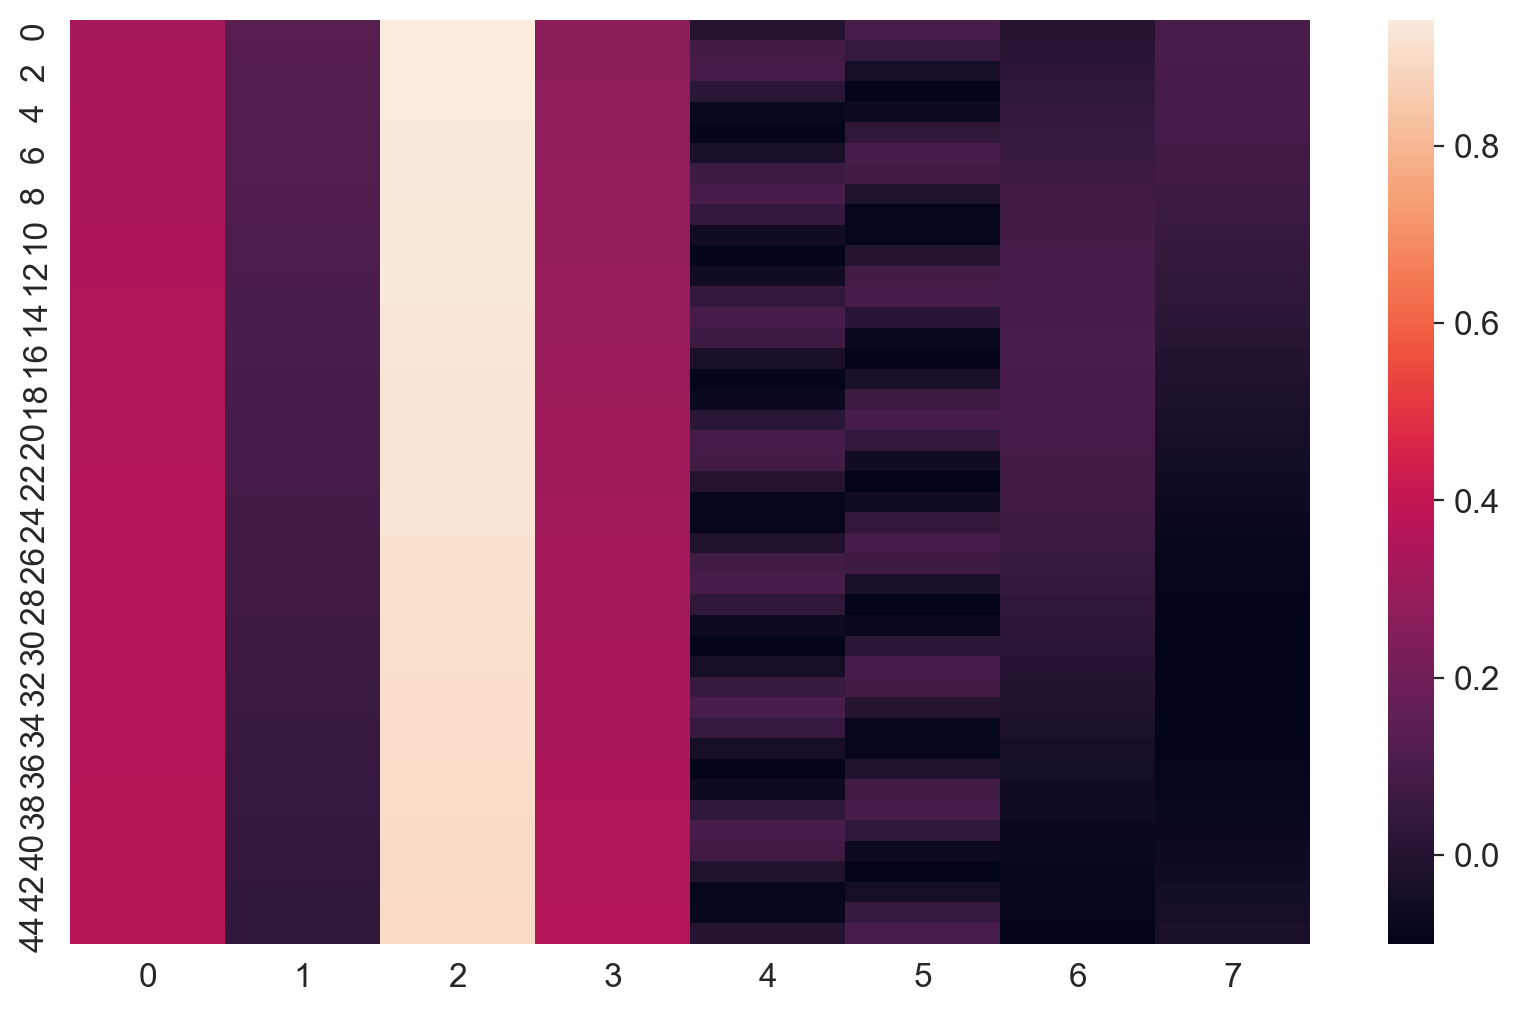

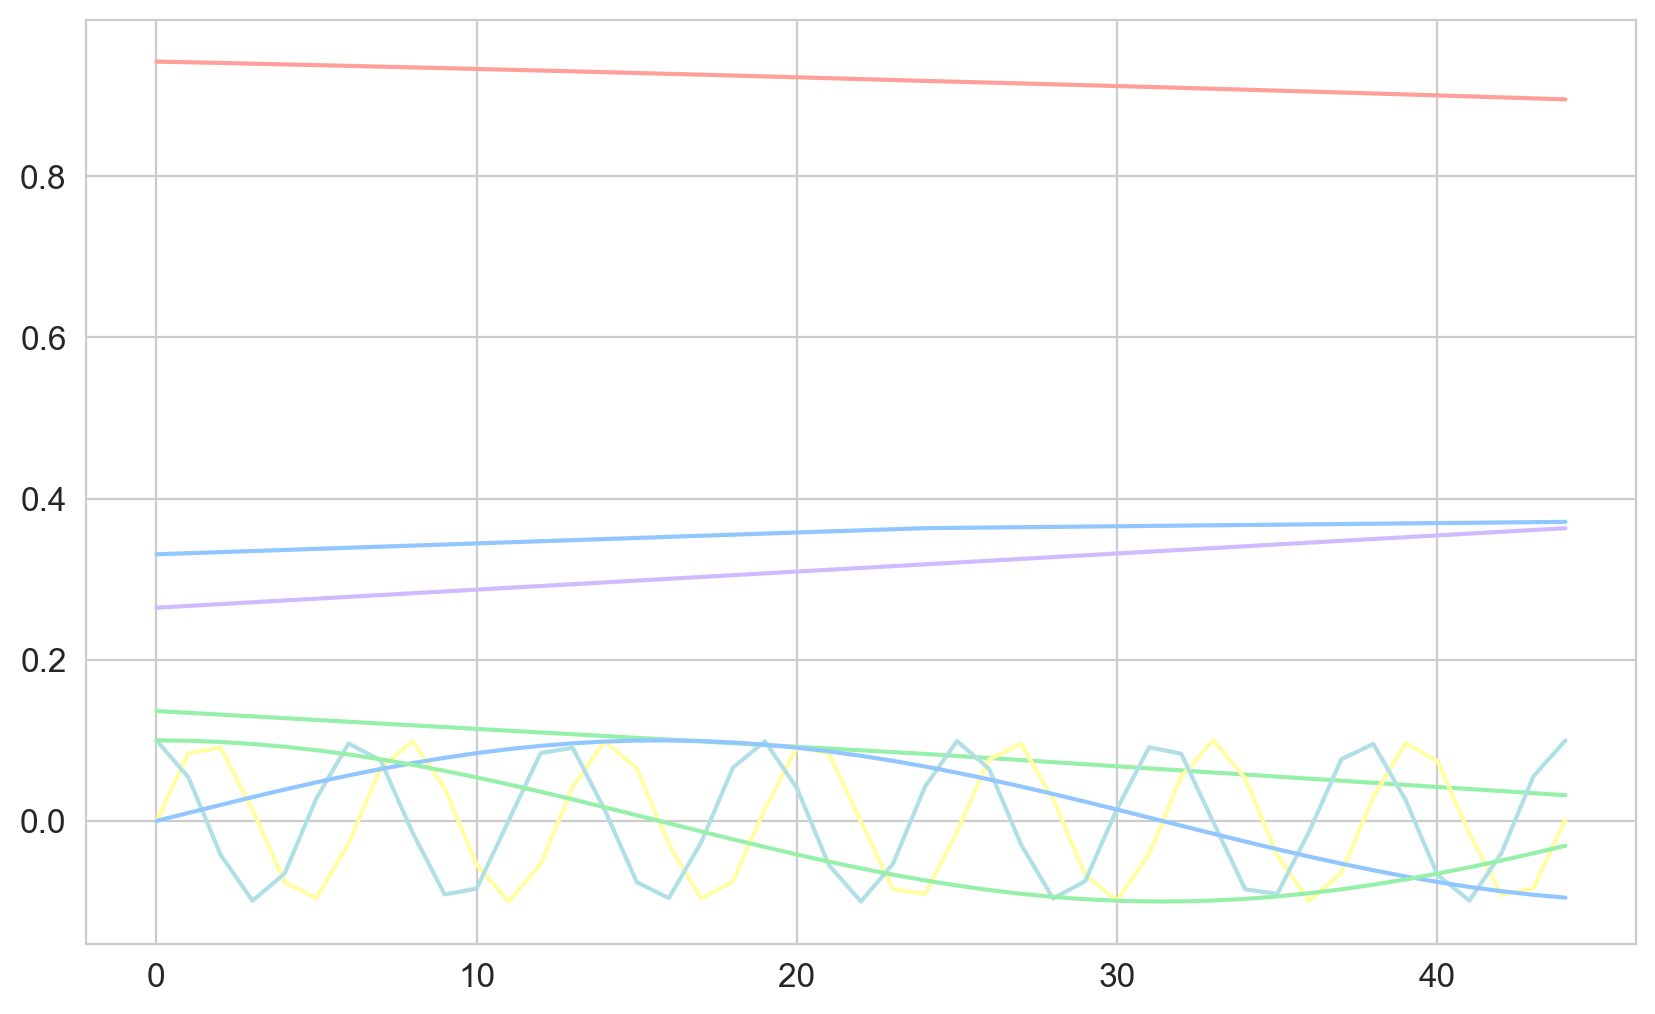

In [118]:
# Checking encondings with incomplete batch
# that requires padding
# Suggests positional encodings should be softened?

positional = PositionalEncoding(
    d_model=ENCODING_DIM, max_len=SAMPLES, dropout=0, device=DEVICE
)

iterator = iter(train_dataloader)
next(iterator)
next(iterator)
next(iterator)
next(iterator)
x, y = next(iterator)
after = positional(x[1:2].to(DEVICE))
after = after.cpu()

sns.heatmap(torch.squeeze(after))
plt.show()

plt.plot(after[0, :, :])
plt.show()

In [119]:
# Testing padding masks creation

print((np.isnan(x[:, :, 0]) == 1)[0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])


### Autoregressive mask

In [120]:
def create_autoregressive_sequence_mask(samples, min_uncovered=0):
    # Triangular matrix
    mask = torch.triu(torch.ones((samples, samples)), diagonal=1)
    # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float("-inf"))
    # Convert ones to 0
    mask = mask.masked_fill(mask == 0, float(0.0))
    mask[:, 0:min_uncovered] = 0
    return mask

In [121]:
SEQUENCE_MASK = create_autoregressive_sequence_mask(samples=SAMPLES).to(DEVICE)
SEQUENCE_MASK.shape, SEQUENCE_MASK[0]

(torch.Size([45, 45]),
 tensor([0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
         -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]))

### Special autoregressive mask that provides batch of initial samples

* Not used because it makes no sense with PyTorch nn.Transformer model

In [122]:
# SEQUENCE_MASK_MIN_VISIBLE = create_autoregressive_sequence_mask(
#     samples=SAMPLES, min_uncovered=MINSAMPLES - 1
# ).to(DEVICE)
# SEQUENCE_MASK_MIN_VISIBLE.shape, SEQUENCE_MASK_MIN_VISIBLE[0]

In [123]:
class TP_transformer(nn.Module):

    def __init__(
        self,
        num_positions=SAMPLES,
        encoding_layers=ENCODING_LAYERS,
        decoding_layers=DECODING_LAYERS,
        encoding_dim=ENCODING_DIM,
        embedding_dim=EMBEDDING_DIM,
        heads=HEADS,
        dropout_positional=0.1,
        dropout_transformer=0.1,
        device=DEVICE,
    ):
        super().__init__()
        self.num_positions = num_positions
        self.positional_encoder = PositionalEncoding(
            d_model=encoding_dim,
            max_len=num_positions,
            dropout=dropout_positional,
        )
        self.transformer = nn.Transformer(
            d_model=embedding_dim + encoding_dim,
            nhead=heads,
            num_encoder_layers=encoding_layers,
            num_decoder_layers=decoding_layers,
            dim_feedforward=num_positions,
            dropout=dropout_transformer,
            activation="relu",
            batch_first=True,  # Consistent with modified PositionalEncoding
            device=device,
        )
        self.linear = nn.Linear(
            in_features=ENCODING_DIM + EMBEDDING_DIM,
            out_features=EMBEDDING_DIM,
        )

    def forward(self, X, Y, tgt_mask, src_pad_mask, tgt_pad_mask):

        D = Y - X
        xp = self.positional_encoder(X)
        yp = self.positional_encoder(D)

        z = self.transformer(
            src=xp,
            tgt=yp,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_pad_mask,
            tgt_key_padding_mask=tgt_pad_mask,
        )

        z = self.linear(z)
        return z


model = TP_transformer()
model.to(DEVICE)

TP_transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
          )
          (linear1): Linear(in_features=8, out_features=45, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=45, out_features=8, bias=True)
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (

In [124]:
# Making padding masks and
# testing a batch

tp = TP_transformer(num_positions=SAMPLES, device=DEVICE)
X, Y = next(iterator)

M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
M = M.to(DEVICE)
X = torch.nan_to_num(X).to(DEVICE)
Y = torch.nan_to_num(Y).to(DEVICE)

O = tp(X, Y, SEQUENCE_MASK, M, M)
O, M.sum()

(tensor([[[-0.0628,  0.9268, -0.1089, -1.2936],
          [-0.2522,  0.5633, -0.4227, -0.2177],
          [-0.0332,  0.7654, -0.7581, -0.4293],
          ...,
          [-0.3915,  0.5783,  0.4266, -0.5568],
          [-0.6822,  0.3323,  0.6822, -0.3506],
          [-0.0879,  0.3086,  0.5529, -1.1054]],
 
         [[ 0.4387,  0.8094, -0.5093, -1.4461],
          [-0.5034,  1.0681, -0.2217, -0.7293],
          [-0.7251,  0.8212, -0.1093, -0.3186],
          ...,
          [-0.7125,  0.3713,  0.5148, -0.2392],
          [-0.0402,  0.4236,  0.3665, -1.0290],
          [-0.5711, -0.1151,  0.7165,  0.3174]],
 
         [[-0.0222,  0.1710, -0.4065, -1.0502],
          [-0.7142,  0.6456, -0.2209, -0.1898],
          [-0.3301,  0.5583, -0.5020,  0.3923],
          ...,
          [-0.8057,  0.5057,  0.2857,  0.1692],
          [-0.6878,  0.2768,  0.7577, -0.2987],
          [ 0.1219, -0.1812,  0.2816, -1.1850]],
 
         ...,
 
         [[-0.3848,  0.7345, -0.3661, -0.7910],
          [-0.7732

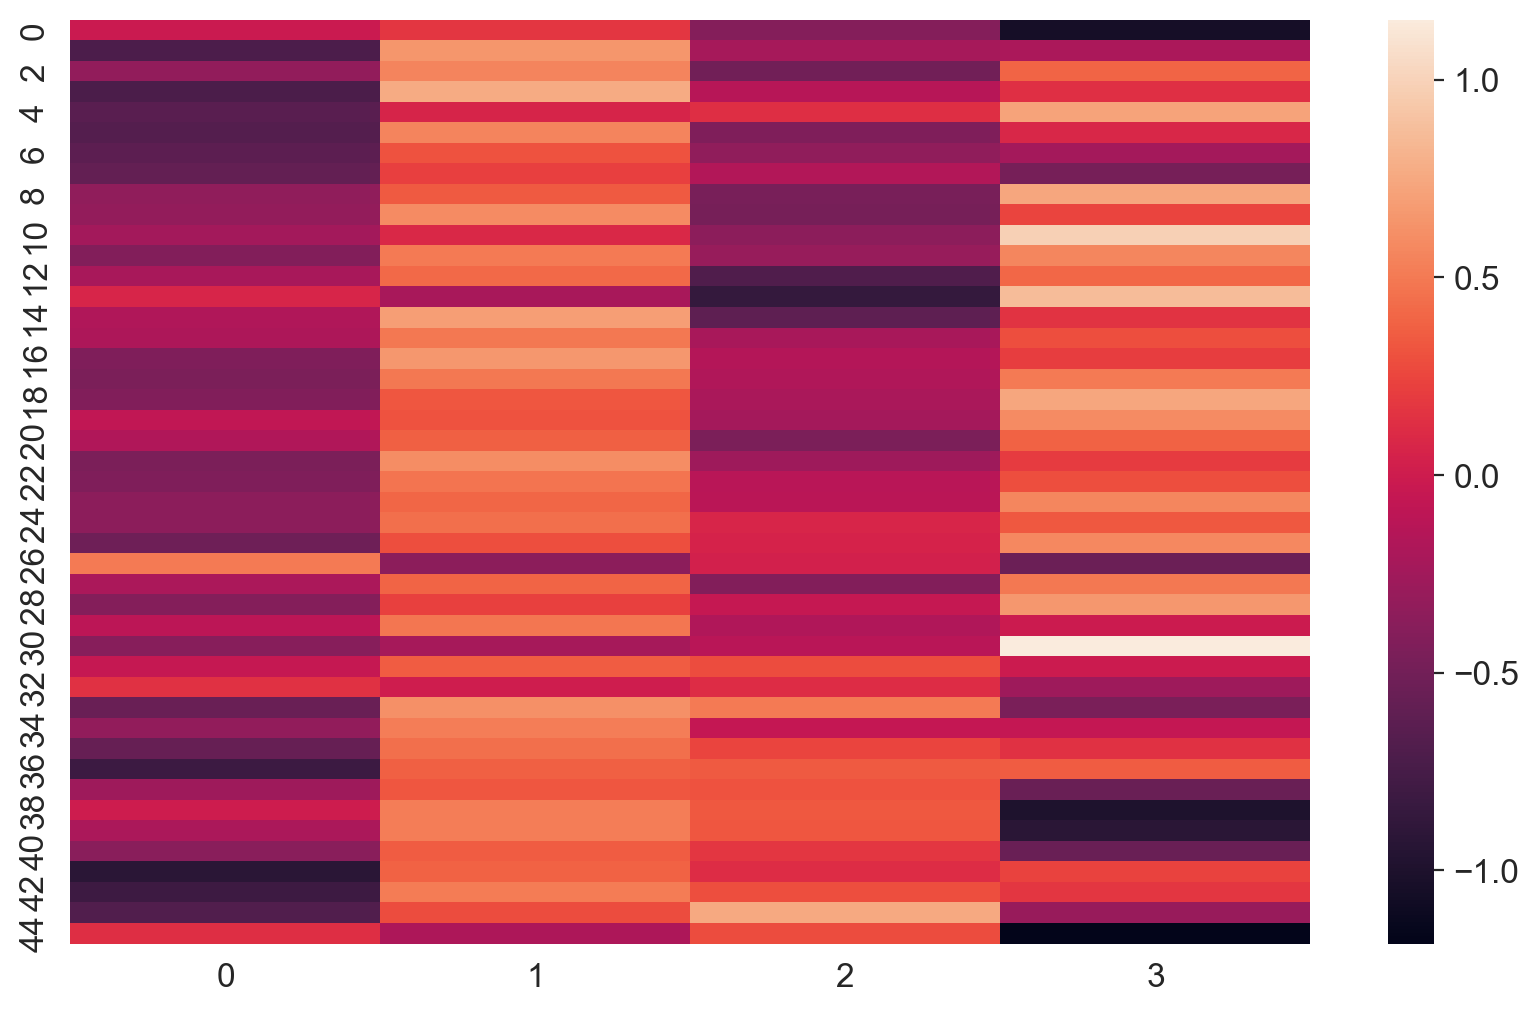

In [125]:
sns.heatmap(torch.squeeze(O[2]).cpu().detach().numpy())
plt.show()

Verifying if loss function requires transformation

In [126]:
# This means I can use MSELoss without issues
# as results when NaNs are present are the same

loss = nn.MSELoss()(O.to(DEVICE), Y)
trues = M.sum()

M.to(DEVICE)
MO = torch.masked_select(O, ~M[:, :, None]).to(DEVICE)
MY = torch.masked_select(Y, ~M[:, :, None]).to(DEVICE)
filtered_loss = nn.MSELoss()(MO, MY)

O.shape, Y.shape, M[:, :, None].shape, loss, trues, MO.shape, MY.shape, loss

(torch.Size([16, 45, 4]),
 torch.Size([16, 45, 4]),
 torch.Size([16, 45, 1]),
 tensor(0.4655, grad_fn=<MseLossBackward0>),
 tensor(82),
 torch.Size([2552]),
 torch.Size([2552]),
 tensor(0.4655, grad_fn=<MseLossBackward0>))

# Training the model

### Using MSELoss and Adam optimizer

Coded to only take into account the loss of the prediction embedding part and to ignore the NaNs

In [127]:
# Building model, optimizer, loss

model = TP_transformer(
    num_positions=SAMPLES,
    encoding_layers=ENCODING_LAYERS,
    decoding_layers=DECODING_LAYERS,
    encoding_dim=ENCODING_DIM,
    embedding_dim=EMBEDDING_DIM,
    dropout_positional=DROPOUT_POSITIONAL,
    dropout_transformer=DROPOUT_TRANSFORMER,
    heads=HEADS,
    device=DEVICE,
)

In [128]:
model.name = (
    f"tptrans4D{ENCODING_LAYERS}" + "drop"
    if DROPOUT_POSITIONAL > 0
    else "" + "lin"
)
model.name

'tptrans4D4drop'

In [129]:
LOAD_MODEL = False
LOAD_PATH = "enter name"

if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_PATH, weights_only=True))

In [130]:
# Global variables to allow interrupting the training

global_epoch_number = 1  # will keep the epoch number within runs
best_dev_loss = 1  # will keep record of best dev loss

In [131]:
# Loss and optimizer

LEARNING_RATE = 0.001  # initial 0.001, may go down to 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss = nn.MSELoss()

### Epoch Training loop function

In [132]:
def train_one_epoch(model, optimizer, loss_fn, epoch_index, writer, device):
    """
    Implementation of one epoch train
    """
    running_loss = 0.0
    last_loss = 0.0

    model.train()
    for i, data in enumerate(train_dataloader):  # could be iter()
        X, Y = data
        M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
        M = M.to(device)
        X = torch.nan_to_num(X).to(device)
        Y = torch.nan_to_num(Y).to(device)

        optimizer.zero_grad()
        O = model(
            X,  # src to encoder
            Y,  # tgt to decoder
            SEQUENCE_MASK,  # tgt autoregressive mask
            M,  # padding mask src
            M,  # padding mask tgt
        )
        loss = loss_fn(O, Y)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print(f"  batch {i + 1} loss: {round(last_loss,6)}")
            tb_x = epoch_index * len(train_dataloader) + i + 1
            writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

### To test dev loss

In [133]:
def dataset_average_loss(model, dataloader, loss_fn, device):
    """
    Loss of a given set, to be used with dev or test
    """
    running_dev_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(dataloader):
            X, Y = vdata
            M = torch.isnan(X[:, :, 0]) == 1  # True where NaNs
            M = M.to(device)
            X = torch.nan_to_num(X).to(device)
            Y = torch.nan_to_num(Y).to(device)
            O = model(
                X,  # src to encoder
                Y,  # tgt to decoder
                SEQUENCE_MASK,  # tgt autoregressive mask
                M,  # padding mask src
                M,  # padding mask tgt
            )
            dev_loss = loss_fn(O, Y)
            running_dev_loss += dev_loss

    return float(running_dev_loss / (i + 1))

### Main Training Loop function

In [134]:
def train_model(
    model,
    optimizer,
    loss_fn,
    epochs,
    writer,
    model_path,
    device,
):
    """
    Implements training loop
    """

    global global_epoch_number
    global best_dev_loss

    for _ in range(epochs):
        print(f"EPOCH {global_epoch_number}:")

        avg_train_loss = train_one_epoch(
            model=model,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epoch_index=global_epoch_number,
            writer=writer,
            device=device,
        )

        avg_dev_loss = dataset_average_loss(
            model=model,
            dataloader=dev_dataloader,
            loss_fn=loss_fn,
            device=device,
        )

        print(
            f"LOSS train {round(number=avg_train_loss,ndigits=6)}"
            + f" valid {round(number=avg_dev_loss,ndigits=6)}"
        )

        writer.add_scalars(
            "Training vs. Validation Loss",
            {
                "Training": avg_train_loss,
                "Validation": avg_dev_loss,
            },
            global_epoch_number + 1,
        )
        writer.add_scalars(
            "Learning Rate",
            {
                "LR": optimizer.param_groups[0]["lr"],
            },
            global_epoch_number + 1,
        )
        writer.flush()

        # Track best performance, and save the model's state
        if avg_dev_loss < best_dev_loss:
            best_dev_loss = avg_dev_loss
            torch.save(
                model.state_dict(), model_path + f"_{global_epoch_number}"
            )
            torch.save(model, model_path + f"_{global_epoch_number}.pt")

        global_epoch_number += 1

### Setting up Tensorboard run

In [136]:
# Only for new runs!
# Separated so the run can be extended manually, do not execute again on same run
#
# Already used:
# * tptrans3drop: 3transformer layers and dropoff
# * tptrans3: 3 transformer layers


timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
writer = SummaryWriter(f"runs/{model.name}_{timestamp}")
model_path = f"save/{model.name}_{timestamp}"

## Training execution



In [ ]:
train_model(
    model=model,
    optimizer=optimizer,
    loss_fn=loss,
    epochs=10,
    writer=writer,
    model_path=model_path,
    device=DEVICE,
)

EPOCH 1:
  batch 1000 loss: 0.025401
  batch 2000 loss: 0.006819
  batch 3000 loss: 0.004857
  batch 4000 loss: 0.003938
  batch 5000 loss: 0.003162
  batch 6000 loss: 0.002745
  batch 7000 loss: 0.0023
  batch 8000 loss: 0.001926
  batch 9000 loss: 0.001811
  batch 10000 loss: 0.00157
  batch 11000 loss: 0.001565
  batch 12000 loss: 0.001458
  batch 13000 loss: 0.001423
  batch 14000 loss: 0.00135


## Training and dev accuracy progression

In [ ]:
def show_train_dev(filetrain, filedev, delta=None):
    history1 = pd.read_csv(filetrain)
    history2 = pd.read_csv(filedev)

    if delta:
        history1["Step"] = history1["Step"] - delta
        history2["Step"] = history2["Step"] - delta

    hist = (
        history1.set_index("Step")
        .join(
            history2.set_index("Step"),
            rsuffix=" validation",
            lsuffix=" training",
        )
        .drop(["Wall time training", "Wall time validation"], axis=1)
    )
    hist["Value validation"] = hist["Value validation"].interpolate(
        method="linear"
    )
    hist.plot()
    plt.ylim((0, 0.003))
    plt.xlim((0, 300000))
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show()

### 4-layer transformer model with dropoff, 4D inputs and delta from FPL to track projection

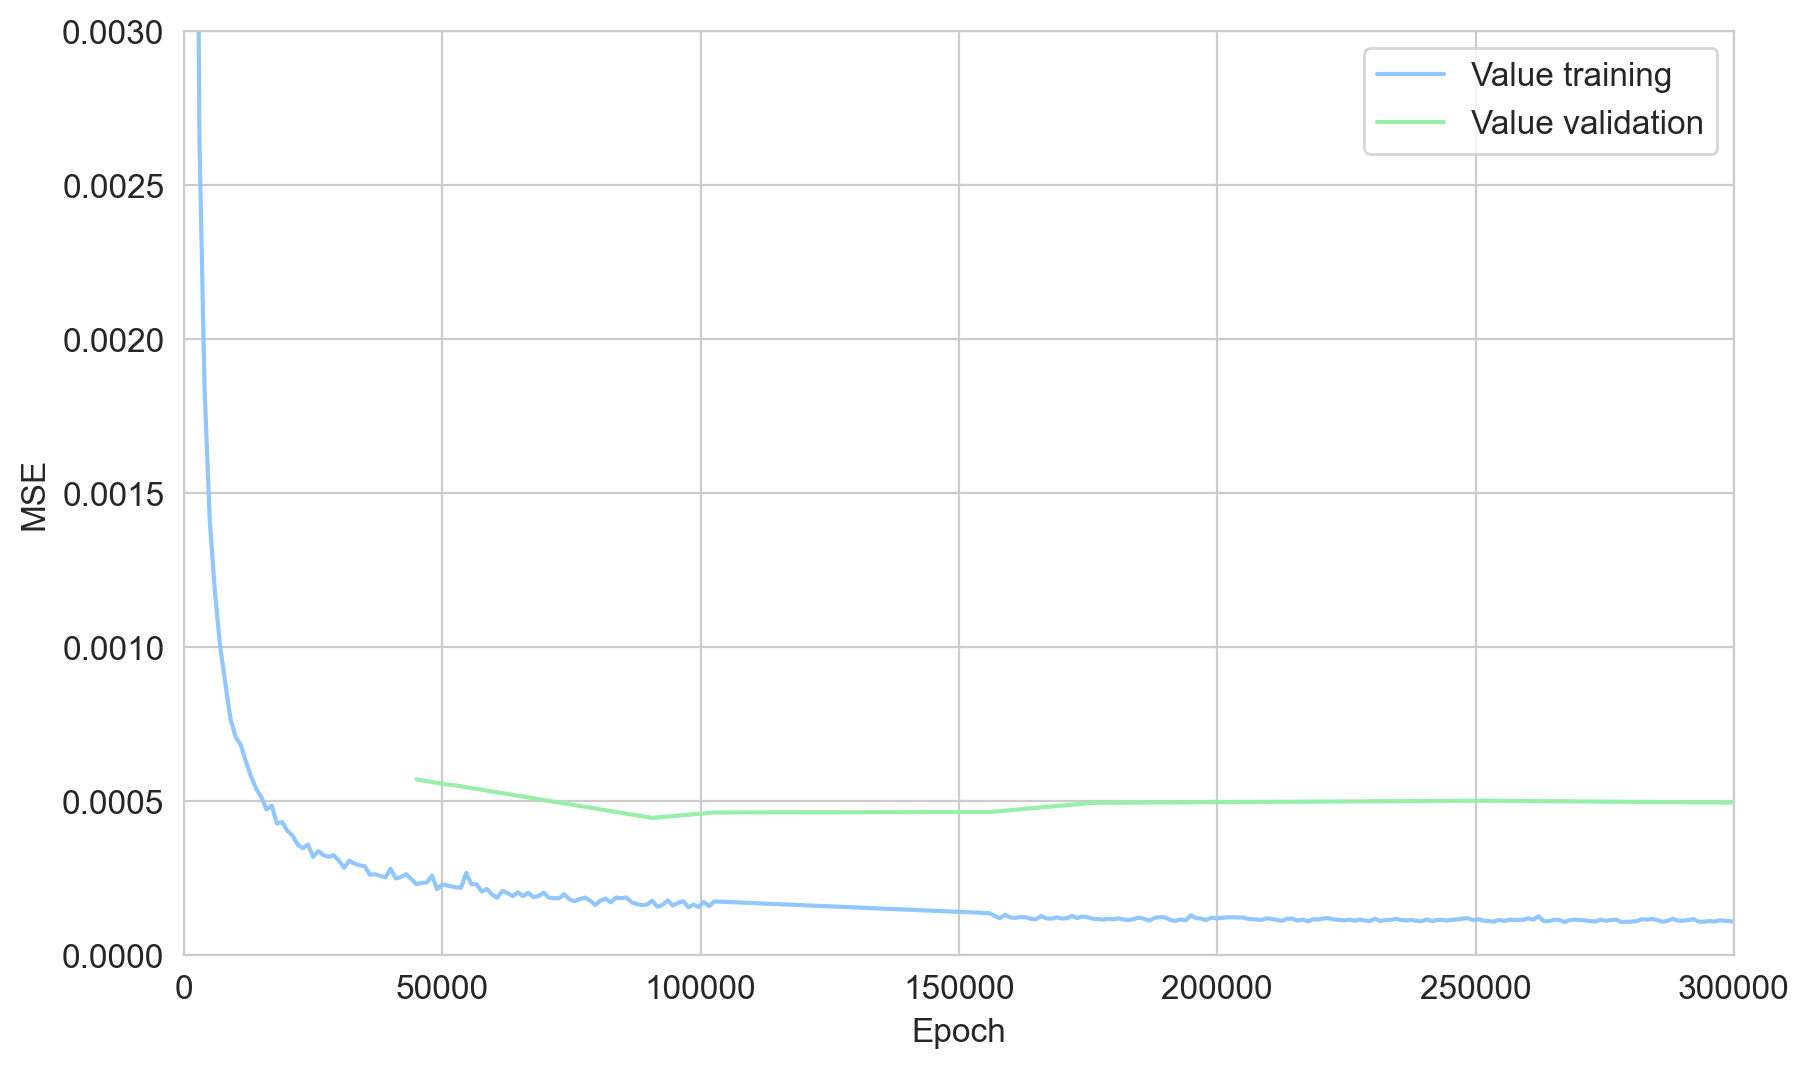

In [97]:
show_train_dev(
    "logs/tptrans3drop_training.csv",
    "logs/tptrans3drop_validation.csv",
)

# Flight trajectory prediction using the model

In [111]:
def predict(model, match, point, minlength, length, device=DEVICE):

    Y = torch.tensor(
        match.iloc[point : point + length][
            ["Trk_E_norm", "Trk_N_norm", "Trk_U_norm"]
        ].to_numpy()[None, :, :],
        dtype=torch.float,
    ).to(device)
    X = torch.tensor(
        match.iloc[point : point + length][
            ["Prj_E_norm", "Prj_N_norm", "Prj_U_norm"]
        ].to_numpy()[None, :, :],
        dtype=torch.float,
    ).to(device)
    unix = match.iloc[point : point + length]["Unix"].to_numpy()
    result = np.zeros((length, 3))

    first = True
    model.eval()
    with torch.no_grad():
        for i in range(minlength, length):
            mask = torch.tensor(
                (np.linspace(0, length - 1, length) > i)[None, :]
            ).to(device)
            pred = model(X, Y, None, None, mask)[:, :, 0:3]
            if first:
                result = pred[0]
                first = False
            else:
                result[i] = pred[0, i]

    result = Fl.undo_transform(data=result, transform=TRANSFORMATION)
    return result, unix

### Select random flight from the test set

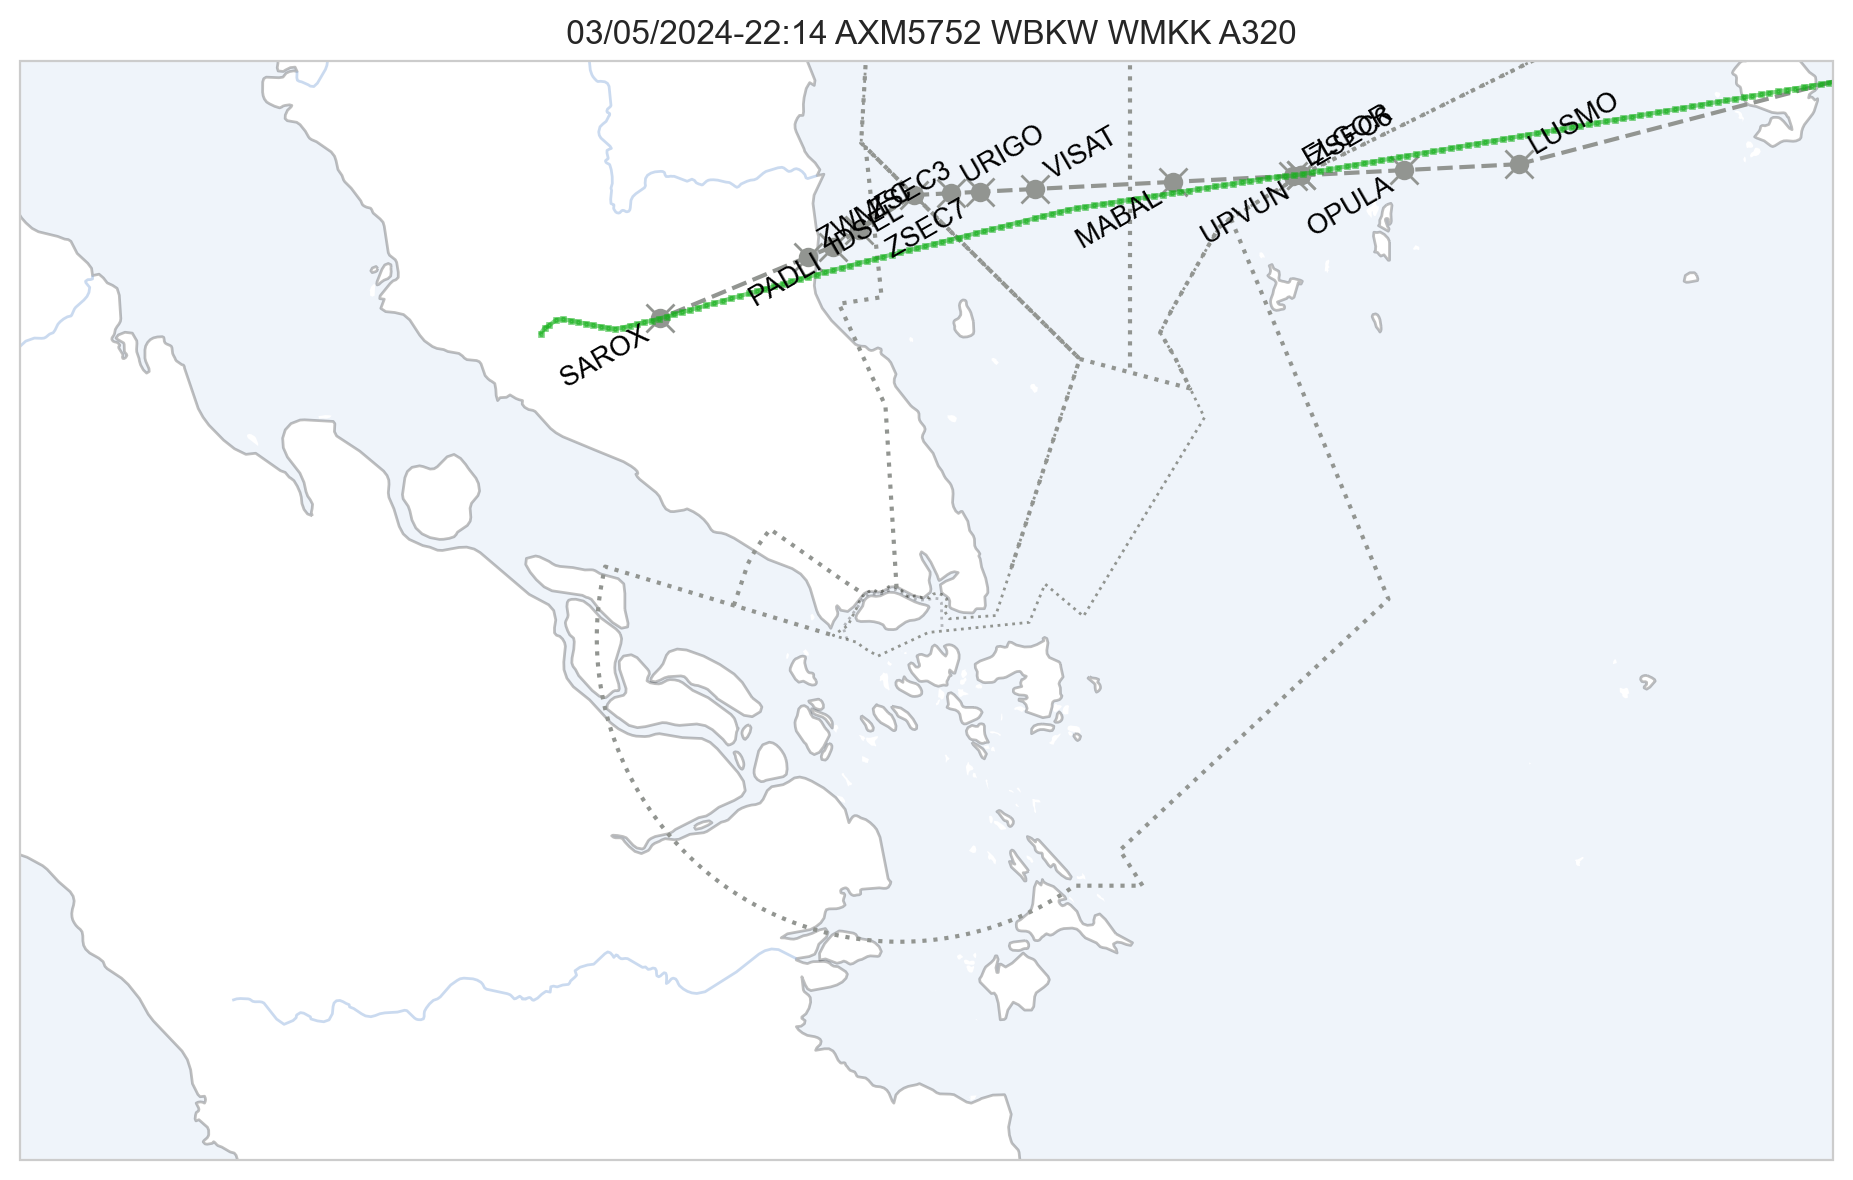

In [206]:
flight: Fl = random.choice(test.flights)
flight.plot(ratio=0.6, wide=500)

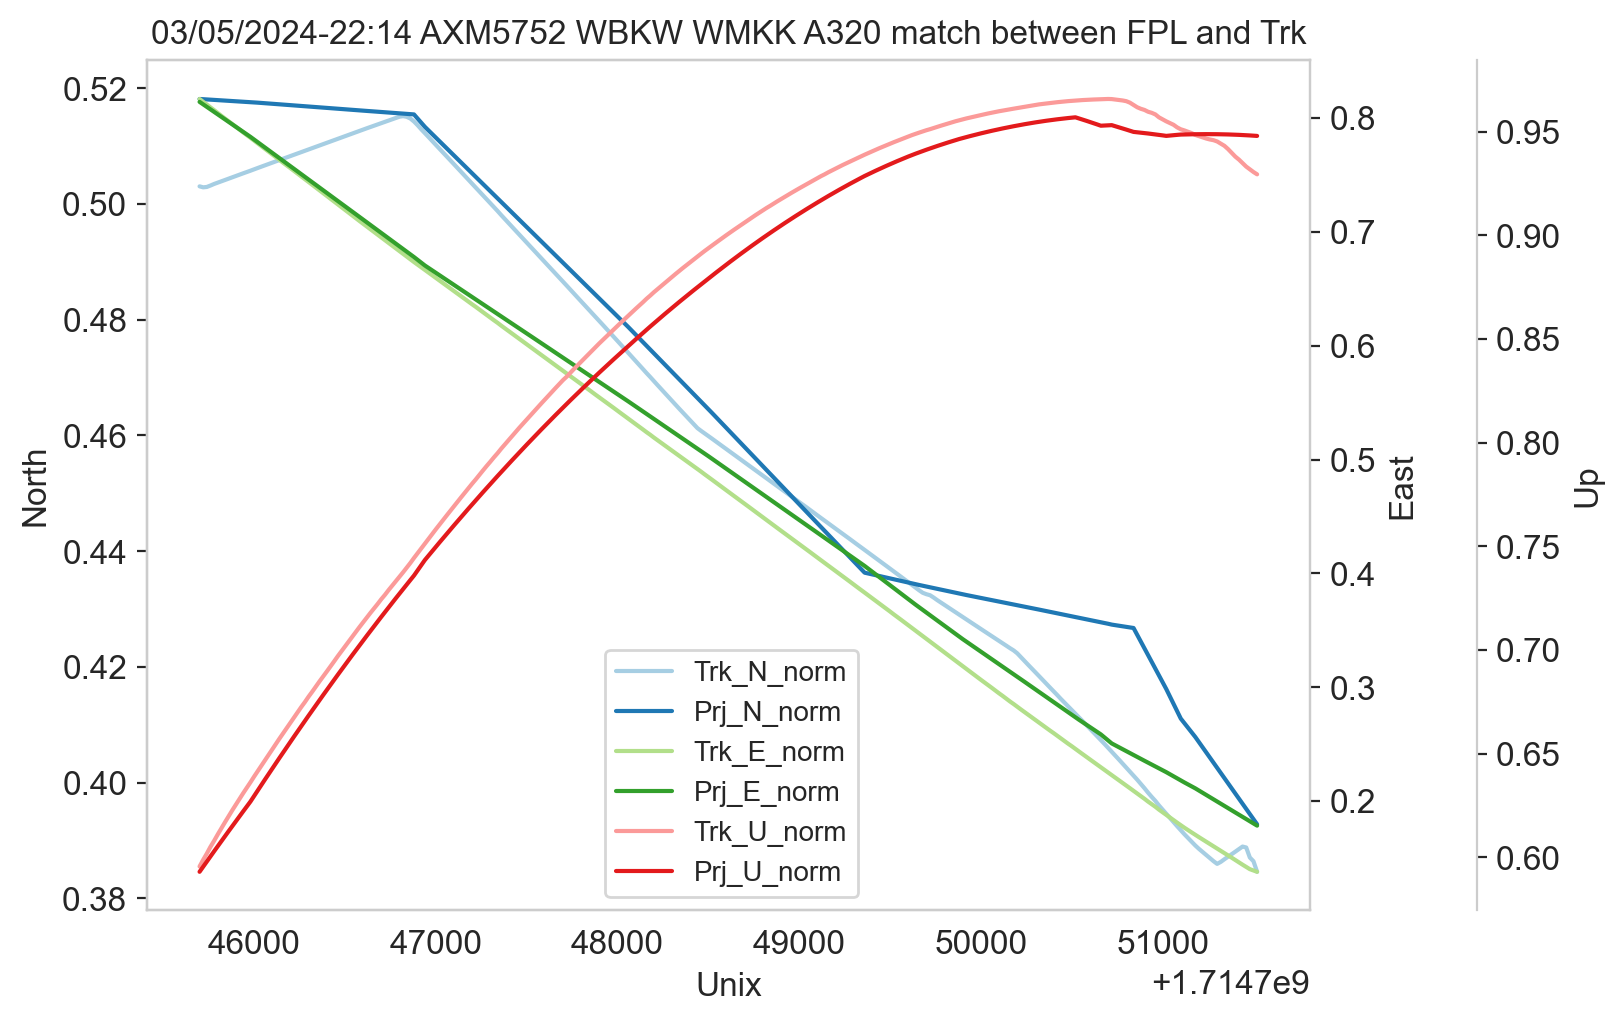

In [207]:
flight.full_match_to_enu_transform(TRANSFORMATION).plot_match(
    geo=False, norm=True
)

In [210]:
predictions = [
    predict(
        model=model,
        match=flight.match,
        point=p * 40,
        minlength=MINSAMPLES - 1,
        length=SAMPLES,
    )
    for p in range(6)
]

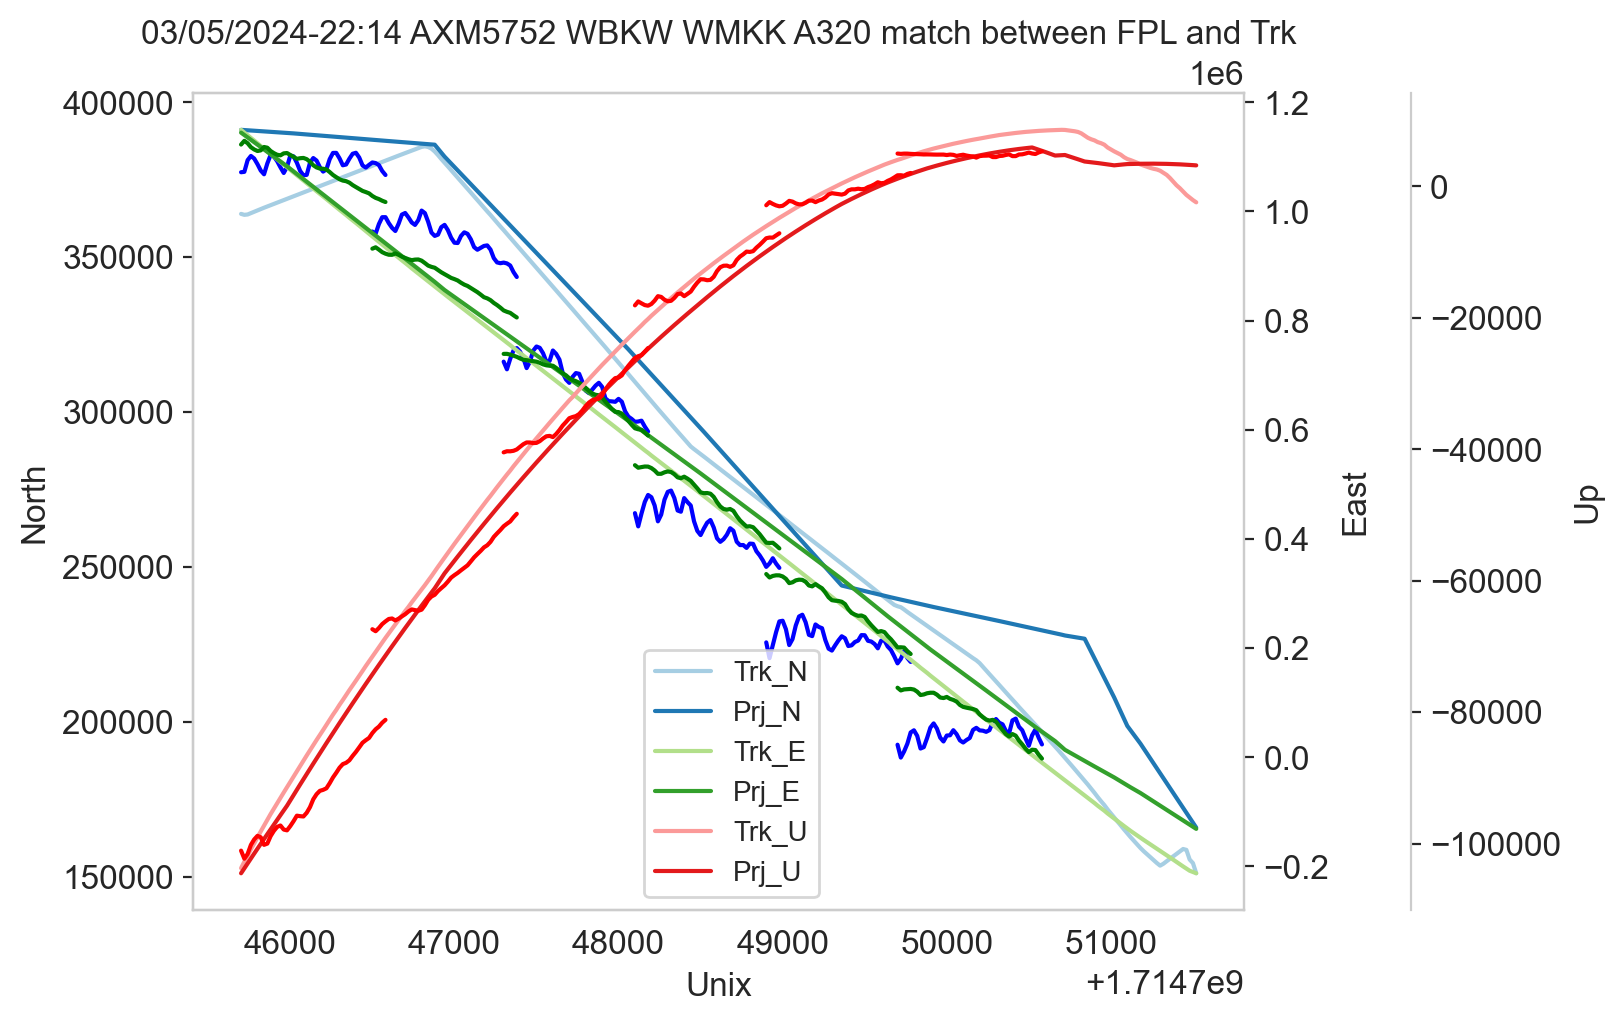

In [211]:
flight.plot_match(geo=False, norm=False, additional=predictions)

In [212]:
def measure_accuracy(model, data_set, samples):
    buckets = {
        1: [],
        2: [],
        3: [],
        4: [],
        5: [],
        6: [],
        7: [],
        8: [],
        9: [],
        10: [],
        11: [],
        12: [],
        13: [],
        14: [],
    }
    for _ in range(samples):
        flight = random.choice(data_set.flights)
        if len(flight.match) - 50 > 0:
            point = random.randint(0, len(flight.match) - 50)
            pred, unix = predict(
                model=model,
                match=flight.match,
                point=point,
                minlength=MINSAMPLES - 1,
                length=SAMPLES,
            )
            for bucket_num in range(1, 15):
                buckets[bucket_num].append(
                    math.sqrt(
                        (
                            pred[3 * bucket_num, 0]
                            - flight.match.iloc[point + 3 * bucket_num][
                                "Trk_E"
                            ]
                        )
                        ** 2
                        + (
                            pred[3 * bucket_num, 1]
                            - flight.match.iloc[point + 3 * bucket_num][
                                "Trk_N"
                            ]
                        )
                        ** 2
                    )
                    * Fl.METER_2_NM
                )

    return pd.DataFrame(
        {
            "1m": buckets[1],
            "2m": buckets[2],
            "3m": buckets[3],
            "4m": buckets[4],
            "5m": buckets[5],
            "6m": buckets[6],
            "7m": buckets[7],
            "8m": buckets[8],
            "9m": buckets[9],
            "10m": buckets[10],
            "11m": buckets[11],
            "12m": buckets[12],
            "13m": buckets[13],
            "14m": buckets[14],
        }
    )

In [213]:
buckets = measure_accuracy(model, test, 50)

In [214]:
def error_boxplot(buckets, name):
    """
    Renders boxplot of a model given a set
    of error samples, longitudinal and lateral
    """
    plt.figure()

    buckets.boxplot(
        column=[
            "1m",
            "2m",
            "3m",
            "4m",
            "5m",
            "6m",
            "7m",
            "8m",
            "9m",
            "10m",
            "11m",
            "12m",
            "13m",
            "14m",
        ],
        rot=45,
    )
    plt.xlabel("Minutes")
    plt.ylabel("Error (NM)")
    plt.title(f"TP Model: {name}", fontsize=16)

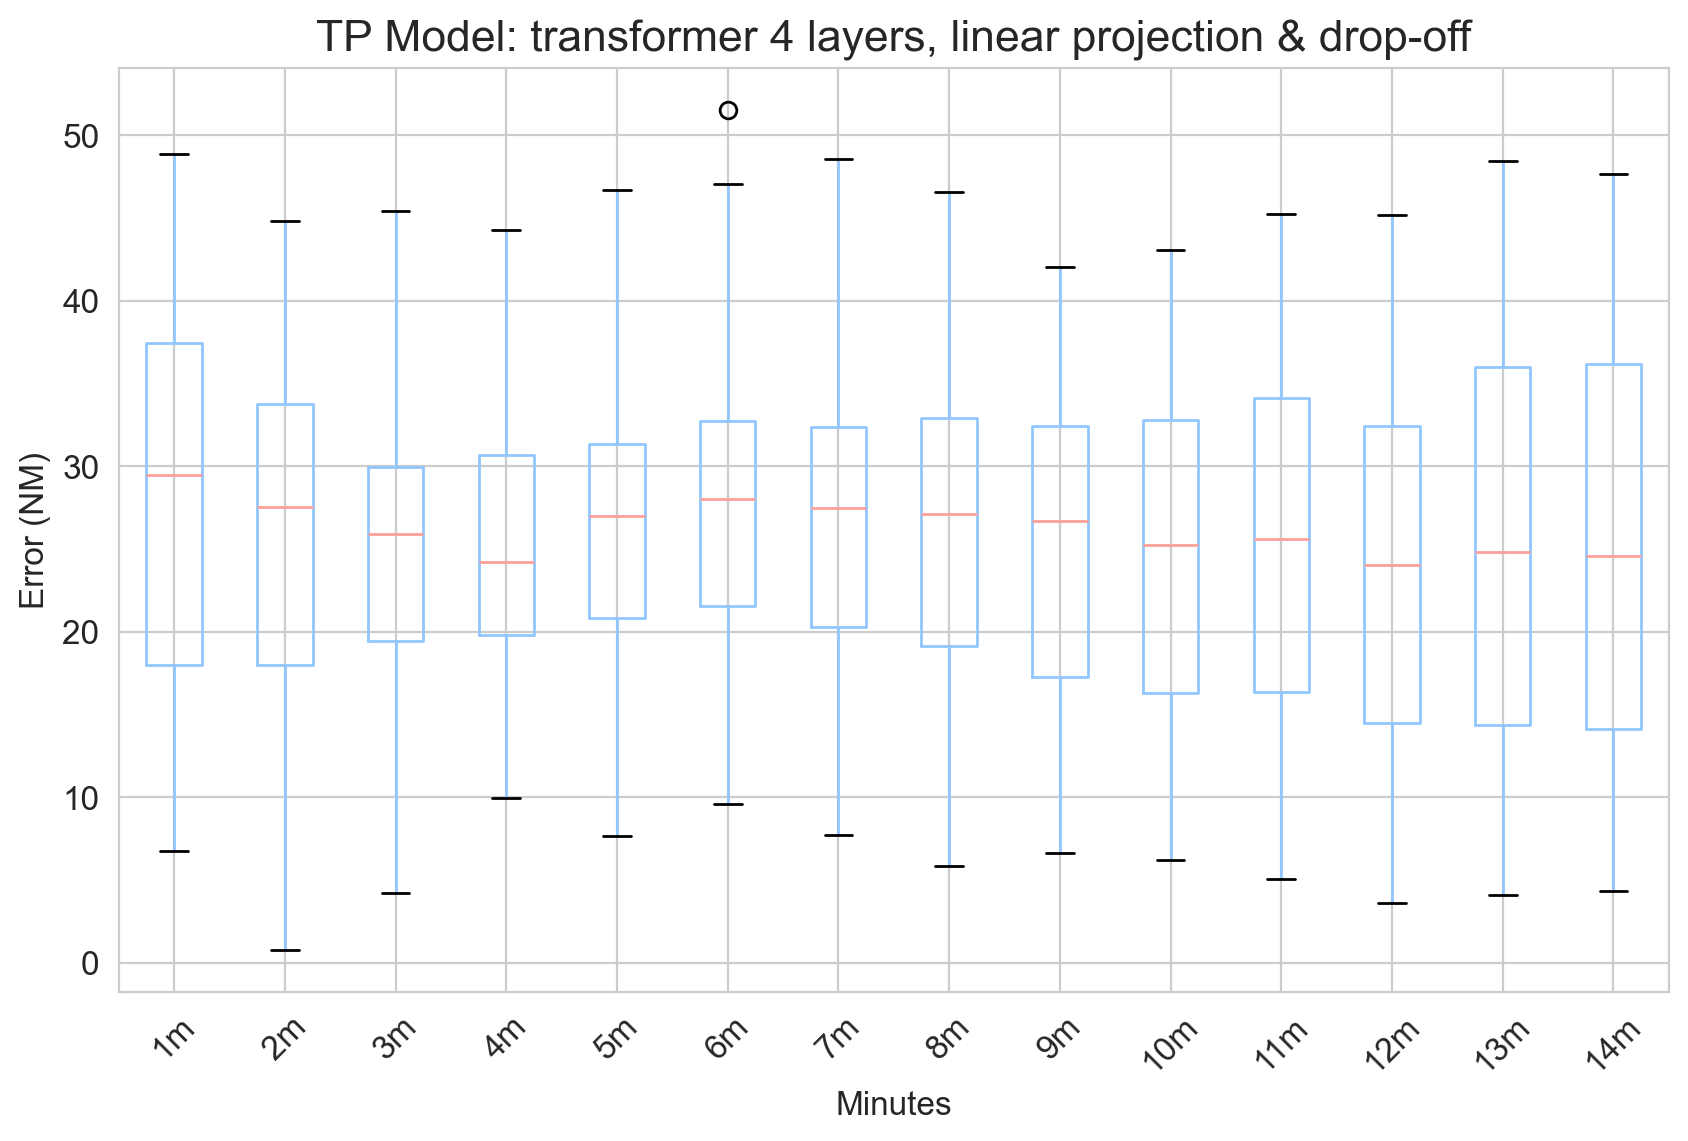

In [215]:
error_boxplot(buckets, "transformer 4 layers, linear projection & drop-off")